### Метрики MLP бейзлайн модели

| Модель                  | Precision@10 | MAP@10  |
|-------------------------|--------------|---------|
| **Matching MLP (CLIP)** | **0.0015**       | **0.0047** |

In [ ]:
# Импортируем основные библиотеки для работы с данными и Torch
import pandas as pd
import numpy as np
import datetime
import random
import torch

### Matching MLP с user-based признаками

В этом блоке мы обучаем базовую модель MatchingMLP на конкатенации эмбеддингов пользователя и товара, а также агрегированных признаков по пользователю.  
Цель — понять, насколько табличные признаки пользователя помогают в задаче рекомендации и могут ли они улучшить метрики Precision@10 и MAP@10.

In [ ]:
# Установка детерминированного поведения для воспроизводимости результатов
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [ ]:
# Загрузка отфильтрованного датасета с пользовательскими взаимодействиями
df = pd.read_csv("data/amazon_interactions_filtered.csv")

In [ ]:
# Фильтрация по времени и разбиение на обучающую и тестовую выборки по таймстемпам
df = df[df["timestamp"] >= pd.Timestamp("2015-01-01").timestamp()].copy()

# Сортировка по времени
df = df.sort_values("timestamp")

# Формируем train/test сплит:
df_train = df[df["timestamp"] < pd.Timestamp("2018-01-01").timestamp()]
df_test = df[(df["timestamp"] >= pd.Timestamp("2018-01-01").timestamp()) &
             (df["timestamp"] < pd.Timestamp("2018-10-01").timestamp())]

In [5]:
# Формируем бинарную метку: label = 1, если рейтинг >= 4
df_train["label"] = (df_train["rating"] >= 4).astype(int)
df_test["label"] = (df_test["rating"] >= 4).astype(int)

C:\Users\Администратор\AppData\Local\Temp\ipykernel_2228\1089353448.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["label"] = (df_train["rating"] >= 4).astype(int)
C:\Users\Администратор\AppData\Local\Temp\ipykernel_2228\1089353448.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["label"] = (df_test["rating"] >= 4).astype(int)


In [6]:
# Подгружаем эмбеддинги и мета-фичи
df_meta_clip = pd.read_csv(
    "data/amazon_meta_clean.csv",
    na_values=[""],
    keep_default_na=False
)
# Переименуем asin в item_id
df_meta_clip.rename(columns={"asin": "item_id"}, inplace=True)

In [7]:
# Удалим tfidf-фичи (они здесь не нужны)
tfidf_cols = [col for col in df_meta_clip.columns if col.startswith("tfidf_")]
df_meta_clip = df_meta_clip.drop(columns=tfidf_cols)

In [ ]:
# Мерджим трейн с фичами товаров после CLIP-энкодера
df_train_merged_clip = df_train.merge(
    df_meta_clip,
    on="item_id",
    how="left"
)

In [9]:
# Отфильтруем данные с пропусками в нижеупомянутых полях
required_fields = ["text_full", "image_main", "brand"]
df_train_clip_clean = df_train_merged_clip.dropna(subset=required_fields).copy()
print(f"После удаления строк без критичных признаков: {len(df_train_clip_clean):,} строк")

После удаления строк без критичных признаков: 1,635,089 строк


In [10]:
# Удалим текст и картинки (они уже в эмбеддингах)
df_train_clip_clean.drop(columns=["text_full", "image_main"], inplace=True)

In [11]:
# Группировка и агрегаты по user_id
user_features = df_train_clip_clean.groupby("user_id").agg({
    "item_id": "count",                                # user_total_interactions
    "rating": "mean",                                  # user_avg_rating
    "timestamp": lambda x: np.mean(np.diff(np.sort(x))),  # user_interaction_freq
    "category_main": pd.Series.nunique,                # user_category_diversity
    "brand": pd.Series.nunique                         # user_brand_diversity
}).rename(columns={
    "item_id": "user_total_interactions",
    "rating": "user_avg_rating",
    "timestamp": "user_interaction_freq",
    "category_main": "user_category_diversity",
    "brand": "user_brand_diversity"
})

c:\Users\Администратор\Desktop\START_ML\Проект\MFDP\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Администратор\Desktop\START_ML\Проект\MFDP\venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [12]:
# Сбросим индекс
user_features = user_features.reset_index()

In [ ]:
# Масштабируем числовые признаки, полученные от юзера
from sklearn.preprocessing import StandardScaler

user_features_scaled = user_features.copy()
feature_cols = [
    "user_total_interactions",
    "user_avg_rating",
    "user_interaction_freq",
    "user_category_diversity",
    "user_brand_diversity"
]

In [14]:
scaler = StandardScaler()
user_features_scaled[feature_cols] = scaler.fit_transform(user_features_scaled[feature_cols])

In [ ]:
# Посмотрим на результат генерации юзер-фичей
user_features_scaled.head()

,user_id,user_total_interactions,user_avg_rating,user_interaction_freq,user_category_diversity,user_brand_diversity
0,A000013090ZI3HIT9N5V,0.103259,0.277802,-0.642299,0.255287,0.333894
1,A0029492Q0J08SOETKZ8,-0.531448,-2.312326,NaN,-0.619433,-0.511305
2,A00408825PVJW7GFLEGU,0.103259,0.277802,0.278635,0.255287,0.333894
3,A0052686GPQNCX2VAZ10,-0.214095,0.601568,-0.645232,-0.619433,-0.088706
4,A0060774I98SJ0AICYQ7,-0.214095,0.115919,2.510580,0.255287,-0.088706


In [16]:
user_features_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611334 entries, 0 to 611333
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   user_id                  611334 non-null  object 
 1   user_total_interactions  611334 non-null  float64
 2   user_avg_rating          611334 non-null  float64
 3   user_interaction_freq    426520 non-null  float64
 4   user_category_diversity  611334 non-null  float64
 5   user_brand_diversity     611334 non-null  float64
dtypes: float64(5), object(1)
memory usage: 28.0+ MB


In [ ]:
# Заполнение пропусков медианой
user_features_scaled["user_interaction_freq"] = user_features_scaled["user_interaction_freq"].fillna(
    user_features_scaled["user_interaction_freq"].median()
)

In [18]:
# Объединяем user_features с основным train-фреймом
df_train_clip_final = df_train_clip_clean.merge(
    user_features_scaled,
    on="user_id",
    how="left"
)

In [ ]:
# Проверка на пропуски
print("Есть ли пропуски после merge:", df_train_clip_final.isna().any().any())

Есть ли пропуски после merge: False


In [20]:
from tqdm import tqdm
import sys
import os


disable_tqdm = os.getenv("TQDM_DISABLE", "0") == "1"

In [ ]:
# Загружаем тестовый датасет и обучающую выборку (rating-based sampling)
# для последующего формирования ground truth
df_test = pd.read_csv("data/df_test_ground_truth_rating_based.csv")

In [ ]:
# Функция Precision@K — средняя доля релевантных товаров среди top-K рекомендаций
def precision_at_k(preds, ground_truth, k=10):
    scores = []
    for user, pred_items in preds.items():
        if user not in ground_truth:
            continue
        gt_items = ground_truth[user]
        hits = sum([1 for item in pred_items[:k] if item in gt_items])
        scores.append(hits / k)
    return round(np.mean(scores), 4)
# Функция average precision для одного пользователя
def apk(pred, actual, k=10):
    if not actual:
        return 0.0
    pred = pred[:k]
    score, num_hits = 0.0, 0.0
    for i, p in enumerate(pred):
        if p in actual and p not in pred[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(actual), k)
# Средняя average precision по всем пользователям
def map_at_k(preds, ground_truth, k=10):
    return round(
        np.mean([
            apk(preds[u], ground_truth[u], k)
            for u in preds if u in ground_truth
        ]),
        4
    )

In [23]:
# Загружаем тренировочную выборку с CLIP-эмбеддингами (текст + изображение)
df_train = df_train_clip_final.copy()

In [24]:
# Выбираем CLIP-эмбеддинги (текст + изображение)
item_vector_cols = [col for col in df_train.columns if col.startswith("clip_text_") or col.startswith("clip_img_")]
user_ids = df_train["user_id"].unique()

In [25]:
# Указываем дополнительные табличные признаки, которые добавим к CLIP-вектору
extra_vec_cols = [
    "title_len",
    "description_text_len",
    "is_top20_brand",
    "has_price",
    "is_top9_category_main",
    "price_clean"
]

In [26]:
# Избавляемся от дубликатов товаров и нормализуем числовые признаки
df_item_extra = df_train.drop_duplicates("item_id")[["item_id"] + extra_vec_cols].copy()

In [ ]:
# Заполним пропуски в price_clean 
df_item_extra["price_clean"] = df_item_extra["price_clean"].fillna(-1)

In [ ]:
# Масштабируем некоторые табличные фичи товара
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_item_extra[["title_len", "description_text_len", "price_clean"]] = scaler.fit_transform(
    df_item_extra[["title_len", "description_text_len", "price_clean"]]
)

In [29]:
# Переводим в индекс item_id для удобного объединения
df_item_extra = df_item_extra.set_index("item_id")

In [30]:
# Извлекаем CLIP-эмбеддинги и объединяем с табличными признаками
clip_vectors  = df_train.drop_duplicates("item_id")[["item_id"] + item_vector_cols].set_index("item_id")

In [31]:
item_vectors = pd.concat([clip_vectors, df_item_extra], axis=1)

In [32]:
print("extra_vectors shape:", df_item_extra.shape)
print("clip_vectors shape:", clip_vectors.shape)
print("item_vectors shape:", item_vectors.shape)

extra_vectors shape: (67706, 6)
clip_vectors shape: (67706, 200)
item_vectors shape: (67706, 206)


In [ ]:
# Установим в датасете с агрегированными фичами юзера user_id в качестве индекса
user_features_indexed = user_features_scaled.set_index("user_id")

In [ ]:
# Формируем вектор интересов пользователя как 
# среднее среднее по эмбеддингам товаров с label = 1
user_vectors = {}

In [ ]:
# Агрегируем признаки по пользователям
for user_id, group in tqdm(df_train[df_train["label"] == 1].groupby("user_id"), desc="User vector aggregation", file=sys.stdout):
    item_ids = group["item_id"].values
    
    # Фильтруем только те item_id, которые есть в item_vectors
    existing_items = [item for item in item_ids if item in item_vectors.index]
    if not existing_items:
        continue

    # Вектор интересов пользователя (только CLIP + item-фичи)
    item_vec_mean = np.mean(item_vectors.loc[item_ids].values, axis=0)
    
    # Подгружаем user-based признаки
    if user_id in user_features_indexed.index:
        user_vec_extra = user_features_indexed.loc[user_id].values
    else:
        user_vec_extra = np.zeros(user_features.shape[1])

    user_vec = np.concatenate([item_vec_mean, user_vec_extra])
    user_vectors[user_id] = user_vec

User vector aggregation: 100%|██████████| 551853/551853 [03:08<00:00, 2935.29it/s]


In [36]:
# Строим датасет: конкатенируем векторы пользователя и товара
X = []
y = []

In [ ]:
# Формируем обучающие пары юзеров и товаров
for row in tqdm(df_train.itertuples(), total=len(df_train), desc="Building training pairs", file=sys.stdout):
    item_id = row.item_id
    user_id = row.user_id
    label = row.label

    if user_id not in user_vectors or item_id not in item_vectors.index:
        continue

    user_vec = user_vectors[user_id]
    item_vec = item_vectors.loc[item_id].values

    concat_vec = np.concatenate([user_vec, item_vec])
    X.append(concat_vec)
    y.append(label)

Building training pairs: 100%|██████████| 1635089/1635089 [02:54<00:00, 9377.72it/s]


In [38]:
# Преобразуем списки в массивы для дальнейшей подачи в PyTorch
X = np.array(X)
y = np.array(y)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1542533, 417)
y shape: (1542533,)


In [39]:
# Импортируем PyTorch и определяем, использовать ли GPU
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [41]:
# Определяем Dataset
class MatchingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [42]:
# Создаём датасет и делим его на обучающую и валидационную части
full_dataset = MatchingDataset(X, y)

In [43]:
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [44]:
# Оборачиваем датасеты в DataLoader для удобной подачи батчами
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2048)

**MatchingMLP**  
Базовая модель: многослойный перцептрон, обучаемый на конкатенированных эмбеддингах пользователя и товара.  
Используется как точка отсчёта (baseline) в бинарной классификации релевантности.

In [ ]:
# Определяем архитектуру бейзлайн MLP модели
class MatchingMLP(nn.Module):
    def __init__(self, input_dim=400):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [46]:
# Создаём экземпляр модели
model = MatchingMLP(input_dim=X.shape[1]).to(device)

In [47]:
# Используем бинарную кросс-энтропию в качестве функции потерь
# и Adam как оптимизатор с learning rate 0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [48]:
from sklearn.metrics import accuracy_score
# Обучаем модель в течение 10 эпох, отслеживая loss и accuracy на валидации
num_epochs = 10

In [ ]:
# Обучение и валидация
for epoch in range(num_epochs):
    model.train()
    train_losses = []

    for X_batch, y_batch in tqdm(train_loader, desc="Training", file=sys.stdout):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).view(-1, 1)

        preds = model(X_batch)
        loss = criterion(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # Валидация
    model.eval()
    val_losses = []
    all_preds = []
    all_targets = []

    for X_batch, y_batch in tqdm(val_loader, desc="Validating", file=sys.stdout):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).view(-1, 1)
        with torch.no_grad():
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
        val_losses.append(loss.item())
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

    # Бинаризуем предсказания, считаем accuracy и выводим метрики за эпоху
    all_preds_bin = (np.array(all_preds) >= 0.5).astype(int)
    val_acc = accuracy_score(all_targets, all_preds_bin)

    tqdm.write(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {np.mean(train_losses):.4f} | "
        f"Val Loss: {np.mean(val_losses):.4f} | "
        f"Val Accuracy: {val_acc:.4f}"
    )

Validating: 100%|██████████| 76/76 [00:01<00:00, 58.14it/s]
Epoch 1/10 | Train Loss: 0.1888 | Val Loss: 0.1276 | Val Accuracy: 0.9495
Validating: 100%|██████████| 76/76 [00:01<00:00, 50.87it/s]
Epoch 2/10 | Train Loss: 0.1161 | Val Loss: 0.0973 | Val Accuracy: 0.9624
Validating: 100%|██████████| 76/76 [00:01<00:00, 50.87it/s]
Epoch 3/10 | Train Loss: 0.0959 | Val Loss: 0.0864 | Val Accuracy: 0.9666
Validating: 100%|██████████| 76/76 [00:01<00:00, 53.30it/s]
Epoch 4/10 | Train Loss: 0.0860 | Val Loss: 0.0807 | Val Accuracy: 0.9690
Validating: 100%|██████████| 76/76 [00:01<00:00, 54.53it/s]
Epoch 5/10 | Train Loss: 0.0794 | Val Loss: 0.0769 | Val Accuracy: 0.9705
Validating: 100%|██████████| 76/76 [00:01<00:00, 54.78it/s]
Epoch 6/10 | Train Loss: 0.0744 | Val Loss: 0.0716 | Val Accuracy: 0.9727
Validating: 100%|██████████| 76/76 [00:01<00:00, 54.81it/s]
Epoch 7/10 | Train Loss: 0.0706 | Val Loss: 0.0715 | Val Accuracy: 0.9727
Validating: 100%|██████████| 76/76 [00:01<00:00, 53.47it/s]
Ep

In [50]:
# Проверяем размер и разнообразие тестового сета перед инференсом
print(f"Test shape: {df_test.shape}, unique users: {df_test['user_id'].nunique()}")

Test shape: (138023, 5), unique users: 85083


In [51]:
# Создаём словарь ground truth: реальные товары, 
# с которыми взаимодействовал пользователь
ground_truth = df_test.groupby("user_id")["item_id"].apply(set).to_dict()

In [52]:
# Переводим модель в режим инференса
model.eval()

MatchingMLP(
  (model): Sequential(
    (0): Linear(in_features=417, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=1, bias=True)
    (6): Sigmoid()
  )
)

In [53]:
# Подготавливаем список кандидатов и их эмбеддинги для инференса
candidate_items = item_vectors.index.tolist()
candidate_vectors = item_vectors.values
candidate_vectors.shape

(67706, 206)

In [ ]:
# Для каждого пользователя генерируем top-N рекомендаций
# Сортировка кандидатов по вероятности релевантности (score)
top_k = 10
predictions = {}

In [ ]:
# Формируем топы рекомендаций для каждого юзера
for user_id in tqdm(ground_truth.keys(), desc="Generating top-N", file=sys.stdout):
    if user_id not in user_vectors:
        continue

    user_vec = user_vectors[user_id]
    user_vec_batch = np.tile(user_vec, (candidate_vectors.shape[0], 1))
    concat = np.hstack([user_vec_batch, candidate_vectors])

    with torch.no_grad():
        scores = model(torch.tensor(concat, dtype=torch.float32).to(device)).cpu().numpy().flatten()

    sorted_items = np.array(candidate_items)[np.argsort(scores)[::-1]]
    predictions[user_id] = sorted_items[:10].tolist()

Generating top-N: 100%|██████████| 85083/85083 [5:57:02<00:00,  3.97it/s]  


In [ ]:
# Считаем метрики на всём списке рекомендаций для случая
# с user-based фичами
print("Matching MLP with user-based features (top-10)")
print("Precision@10:", precision_at_k(predictions, ground_truth))
print("MAP@10:", map_at_k(predictions, ground_truth))

Matching MLP with user-based features (top-10)
Precision@10: 0.0003
MAP@10: 0.0008


### Вывод: Matching MLP с user-based признаками

- Улучшение не дало прироста по сравнению с CLIP + табличными item-фичами.
- Precision@10 и MAP@10 упали ниже базового уровня.
- Возможно, признаки пользователей были недостаточно информативны.
- Не рекомендуется как основная модель.

## Удаление табличных item-фичей и item-векторов

### Matching MLP только на CLIP-эмбеддингах

Здесь мы обучаем MatchingMLP без дополнительных признаков, используя только эмбеддинги из CLIP (текст + изображение).  
Цель — сравнить чисто мультимодальное представление товаров с табличным и оценить его эффективность в модели.

In [55]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
from tqdm import tqdm
import sys
import os
import random
import torch

disable_tqdm = os.getenv("TQDM_DISABLE", "0") == "1"

In [ ]:
# Устанавливаем seed для воспроизводимости
seed_everything(42)

In [57]:
# Загружаем тестовый датасет и обучающую выборку (rating-based sampling)
df_test = pd.read_csv("data/df_test_ground_truth_rating_based.csv")

In [61]:
# Загружаем тренировочную выборку с CLIP-эмбеддингами (текст + изображение)
df_train = pd.read_csv(
    "data/df_train_CLIP_rating_based.csv",
    na_values=[""],  # исключаем "Unknown"
    keep_default_na=False
)

In [62]:
# Выбираем CLIP-эмбеддинги (текст + изображение)
item_vector_cols = [col for col in df_train.columns if col.startswith("clip_text_") or col.startswith("clip_img_")]
user_ids = df_train["user_id"].unique()

In [ ]:
# Извлекаем CLIP-эмбеддинги
clip_vectors  = df_train.drop_duplicates("item_id")[["item_id"] + item_vector_cols].set_index("item_id")

In [ ]:
# Здесь item_vectors будет представлять собой только CLIP-эмбеддинги
item_vectors = clip_vectors.copy()

In [65]:
print("clip_vectors shape:", clip_vectors.shape)
print("item_vectors shape:", item_vectors.shape)

clip_vectors shape: (67706, 200)
item_vectors shape: (67706, 200)


In [66]:
# Формируем вектор интересов пользователя как среднее по позитивным item-векторам
user_vectors = {}

In [ ]:
# Создаем вектор юзера по тому же принципу, что и ранее
for user_id, group in tqdm(df_train[df_train["label"] == 1].groupby("user_id"), desc="User vector aggregation", file=sys.stdout):
    item_ids = group["item_id"].values
    vectors = item_vectors.loc[item_ids].values
    user_vectors[user_id] = np.mean(vectors, axis=0)

User vector aggregation: 100%|██████████| 551853/551853 [02:30<00:00, 3668.75it/s]


In [68]:
# Строим датасет: конкатенируем векторы пользователя и товара
X = []
y = []

In [ ]:
# Формируем обучающие пары юзер-товар
for row in tqdm(df_train.itertuples(), total=len(df_train), desc="Building training pairs", file=sys.stdout):
    item_id = row.item_id
    user_id = row.user_id
    label = row.label

    if user_id not in user_vectors or item_id not in item_vectors.index:
        continue

    user_vec = user_vectors[user_id]
    item_vec = item_vectors.loc[item_id].values

    concat_vec = np.concatenate([user_vec, item_vec])
    X.append(concat_vec)
    y.append(label)

Building training pairs: 100%|██████████| 1635089/1635089 [01:21<00:00, 19953.46it/s]


In [70]:
# Преобразуем списки в массивы для дальнейшей подачи в PyTorch
X = np.array(X)
y = np.array(y)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1542533, 400)
y shape: (1542533,)


In [71]:
# Импортируем PyTorch и определяем, использовать ли GPU
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [73]:
# Определяем Dataset
class MatchingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [74]:
# Создаём датасет и делим его на обучающую и валидационную части
full_dataset = MatchingDataset(X, y)

In [75]:
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [76]:
# Оборачиваем датасеты в DataLoader для удобной подачи батчами
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2048)

**MatchingMLP**  
Базовая модель: многослойный перцептрон, обучаемый на конкатенированных эмбеддингах пользователя и товара.  
Используется как точка отсчёта (baseline) в бинарной классификации релевантности.

In [ ]:
# Определяем архитектуру MLP модели
class MatchingMLP(nn.Module):
    def __init__(self, input_dim=400):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [78]:
# Создаём экземпляр модели
model = MatchingMLP(input_dim=X.shape[1]).to(device)

In [79]:
# Используем бинарную кросс-энтропию в качестве функции потерь
# и Adam как оптимизатор с learning rate 0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [80]:
from sklearn.metrics import accuracy_score
# Обучаем модель в течение 10 эпох, отслеживая loss и accuracy на валидации
num_epochs = 10

In [ ]:
# Обучение
for epoch in range(num_epochs):
    model.train()
    train_losses = []

    for X_batch, y_batch in tqdm(train_loader, desc="Training", file=sys.stdout):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).view(-1, 1)

        preds = model(X_batch)
        loss = criterion(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # Валидация
    model.eval()
    val_losses = []
    all_preds = []
    all_targets = []

    for X_batch, y_batch in tqdm(val_loader, desc="Validating", file=sys.stdout):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).view(-1, 1)
        with torch.no_grad():
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
        val_losses.append(loss.item())
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

    # Бинаризуем предсказания, считаем accuracy и выводим метрики за эпоху
    all_preds_bin = (np.array(all_preds) >= 0.5).astype(int)
    val_acc = accuracy_score(all_targets, all_preds_bin)

    tqdm.write(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {np.mean(train_losses):.4f} | "
        f"Val Loss: {np.mean(val_losses):.4f} | "
        f"Val Accuracy: {val_acc:.4f}"
    )

Validating: 100%|██████████| 76/76 [00:01<00:00, 51.10it/s]
Epoch 1/10 | Train Loss: 0.3089 | Val Loss: 0.2434 | Val Accuracy: 0.9052
Validating: 100%|██████████| 76/76 [00:01<00:00, 47.31it/s]
Epoch 2/10 | Train Loss: 0.1735 | Val Loss: 0.1215 | Val Accuracy: 0.9576
Validating: 100%|██████████| 76/76 [00:01<00:00, 45.45it/s]
Epoch 3/10 | Train Loss: 0.1244 | Val Loss: 0.1056 | Val Accuracy: 0.9635
Validating: 100%|██████████| 76/76 [00:01<00:00, 47.09it/s]
Epoch 4/10 | Train Loss: 0.1122 | Val Loss: 0.1007 | Val Accuracy: 0.9646
Validating: 100%|██████████| 76/76 [00:01<00:00, 47.49it/s]
Epoch 5/10 | Train Loss: 0.1051 | Val Loss: 0.0960 | Val Accuracy: 0.9665
Validating: 100%|██████████| 76/76 [00:01<00:00, 47.28it/s]
Epoch 6/10 | Train Loss: 0.1005 | Val Loss: 0.0932 | Val Accuracy: 0.9676
Validating: 100%|██████████| 76/76 [00:01<00:00, 44.51it/s]
Epoch 7/10 | Train Loss: 0.0967 | Val Loss: 0.0908 | Val Accuracy: 0.9684
Validating: 100%|██████████| 76/76 [00:01<00:00, 48.79it/s]
Ep

In [82]:
# Проверяем размер и разнообразие тестового сета перед инференсом
print(f"Test shape: {df_test.shape}, unique users: {df_test['user_id'].nunique()}")

Test shape: (138023, 5), unique users: 85083


In [83]:
# Создаём словарь ground truth: реальные товары, 
# с которыми взаимодействовал пользователь
ground_truth = df_test.groupby("user_id")["item_id"].apply(set).to_dict()

In [84]:
# Переводим модель в режим инференса
model.eval()

MatchingMLP(
  (model): Sequential(
    (0): Linear(in_features=400, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=1, bias=True)
    (6): Sigmoid()
  )
)

In [85]:
# Подготавливаем список кандидатов и их эмбеддинги для инференса
candidate_items = item_vectors.index.tolist()
candidate_vectors = item_vectors.values
candidate_vectors.shape

(67706, 200)

In [ ]:
# Для каждого пользователя генерируем top-N рекомендаций
# Сортировка кандидатов по вероятности релевантности (score)
top_k = 10
predictions = {}

In [ ]:
# Формируем топы рекомендаций для каждого юзера
for user_id in tqdm(ground_truth.keys(), desc="Generating top-N", file=sys.stdout):
    if user_id not in user_vectors:
        continue

    user_vec = user_vectors[user_id]
    user_vec_batch = np.tile(user_vec, (candidate_vectors.shape[0], 1))
    concat = np.hstack([user_vec_batch, candidate_vectors])

    with torch.no_grad():
        scores = model(torch.tensor(concat, dtype=torch.float32).to(device)).cpu().numpy().flatten()

    sorted_items = np.array(candidate_items)[np.argsort(scores)[::-1]]
    predictions[user_id] = sorted_items[:10].tolist()

Generating top-N: 100%|██████████| 85083/85083 [4:38:09<00:00,  5.10it/s]  


In [ ]:
# Считаем метрики на всём списке рекомендаций для
# случая, когда иы используем только CLIP-фичи
print("Matching MLP (top-10)")
print("Precision@10:", precision_at_k(predictions, ground_truth))
print("MAP@10:", map_at_k(predictions, ground_truth))

Matching MLP (top-10)
Precision@10: 0.0016
MAP@10: 0.0051


### Вывод: Matching MLP только на CLIP-эмбеддингах

- Использование только мультимодальных CLIP-эмбеддингов дало лучшее, пусть и незначительно, качество среди простых моделей.
- Метрики: Precision@10 ≈ 0.0016, MAP@10 ≈ 0.0051.
- Берем за baseline среди простых архитектур.

## Stratified split

### Учёт дисбаланса классов: стратификация и sample weights

Данный блок посвящён корректной работе с сильным дисбалансом в целевой переменной (положительных примеров в 5 раз больше).  
Мы добавляем sample weights и сравниваем два способа учёта: BCEWithLogitsLoss и BCELoss с ручными весами.

In [ ]:
# Устанавливаем seed для воспроизводимости
seed_everything(42)

In [90]:
# Загружаем тренировочную выборку с CLIP-эмбеддингами (текст + изображение)
df_train = pd.read_csv(
    "data/df_train_CLIP_rating_based.csv",
    na_values=[""],  # исключаем "Unknown"
    keep_default_na=False
)

In [91]:
# Выбираем CLIP-эмбеддинги (текст + изображение)
item_vector_cols = [col for col in df_train.columns if col.startswith("clip_text_") or col.startswith("clip_img_")]
user_ids = df_train["user_id"].unique()

In [92]:
# Извлекаем CLIP-эмбеддинги
clip_vectors  = df_train.drop_duplicates("item_id")[["item_id"] + item_vector_cols].set_index("item_id")

In [93]:
item_vectors = clip_vectors.copy()

In [94]:
print("clip_vectors shape:", clip_vectors.shape)
print("item_vectors shape:", item_vectors.shape)

clip_vectors shape: (67706, 200)
item_vectors shape: (67706, 200)


In [95]:
# Формируем вектор интересов пользователя как среднее по позитивным item-векторам
user_vectors = {}

In [ ]:
# Создаем вектор юзера по тому же принципу, что и ранее
for user_id, group in tqdm(df_train[df_train["label"] == 1].groupby("user_id"), desc="User vector aggregation", file=sys.stdout):
    item_ids = group["item_id"].values
    vectors = item_vectors.loc[item_ids].values
    user_vectors[user_id] = np.mean(vectors, axis=0)

User vector aggregation: 100%|██████████| 551853/551853 [02:30<00:00, 3675.05it/s]


In [97]:
# Строим датасет: конкатенируем векторы пользователя и товара
X = []
y = []

In [ ]:
# Формируем обучающие пары
for row in tqdm(df_train.itertuples(), total=len(df_train), desc="Building training pairs", file=sys.stdout):
    item_id = row.item_id
    user_id = row.user_id
    label = row.label

    if user_id not in user_vectors or item_id not in item_vectors.index:
        continue

    user_vec = user_vectors[user_id]
    item_vec = item_vectors.loc[item_id].values

    concat_vec = np.concatenate([user_vec, item_vec])
    X.append(concat_vec)
    y.append(label)

Building training pairs: 100%|██████████| 1635089/1635089 [01:22<00:00, 19762.48it/s]


In [99]:
# Преобразуем списки в массивы для дальнейшей подачи в PyTorch
X = np.array(X)
y = np.array(y)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1542533, 400)
y shape: (1542533,)


In [ ]:
from sklearn.model_selection import train_test_split

# Стратифицированное разбиение по label, он же y
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

In [ ]:
# Формируем облучающие и валидационный Dataset-ы
# для оборачивания их в DataLoader для удобной подачи батчами
train_dataset = MatchingDataset(X_train_np, y_train_np)
val_dataset   = MatchingDataset(X_val_np, y_val_np)

In [102]:
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=2048)

In [103]:
# Подсчет веса классов
n_pos = np.sum(y == 1)
n_neg = np.sum(y == 0)

# Для BCEWithLogitsLoss
pos_weight_tensor = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)

# Для BCELoss — веса отдельно на каждый sample
# Предварительно рассчитаем class weights
pos_weight = (n_neg + n_pos) / (2 * n_pos)
neg_weight = (n_neg + n_pos) / (2 * n_neg)

**MatchingMLP_Logits**  
Та же архитектура, что и MatchingMLP, но без финального Sigmoid.  
Используется вместе с функцией потерь `BCEWithLogitsLoss`, позволяющей корректно учитывать дисбаланс классов.

In [ ]:
# MLP модель с loss - BCEWithLogits
# убираем Sigmoid
class MatchingMLP_Logits(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

**MatchingMLP_Sigmoid**  
Версия модели MatchingMLP с финальным Sigmoid.  
Совместима с функцией потерь `BCELoss` и позволяет применять sample weights вручную.

In [105]:
# Модель с BCELoss (оставляем Sigmoid)
class MatchingMLP_Sigmoid(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [106]:
# BCE with logits
model_logits = MatchingMLP_Logits(input_dim=X.shape[1]).to(device)
criterion_logits = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer_logits = torch.optim.Adam(model_logits.parameters(), lr=1e-3)

In [107]:
# BCE
model_sigmoid = MatchingMLP_Sigmoid(input_dim=X.shape[1]).to(device)
criterion_sigmoid = nn.BCELoss(reduction="none")
optimizer_sigmoid = torch.optim.Adam(model_sigmoid.parameters(), lr=1e-3)

In [108]:
from sklearn.metrics import accuracy_score
# Обучаем модель в течение 10 эпох, отслеживая loss и accuracy на валидации
num_epochs = 10

In [ ]:
# Обучение модели MatchingMLP_Logits
for epoch in range(num_epochs):
    model_logits.train()
    train_losses = []

    for X_batch, y_batch in tqdm(train_loader, desc="Training", file=sys.stdout):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).view(-1, 1)

        preds = model_logits(X_batch)
        loss = criterion_logits(preds, y_batch)

        optimizer_logits.zero_grad()
        loss.backward()
        optimizer_logits.step()

        train_losses.append(loss.item())

    # Валидация
    model_logits.eval()
    val_losses = []
    all_preds = []
    all_targets = []

    for X_batch, y_batch in tqdm(val_loader, desc="Validating", file=sys.stdout):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).view(-1, 1)
        with torch.no_grad():
            preds = model_logits(X_batch)
            loss = criterion_logits(preds, y_batch)
        val_losses.append(loss.item())
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

    # Бинаризуем предсказания, считаем accuracy и выводим метрики за эпоху
    all_preds_bin = (np.array(all_preds) >= 0.5).astype(int)
    val_acc = accuracy_score(all_targets, all_preds_bin)

    tqdm.write(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {np.mean(train_losses):.4f} | "
        f"Val Loss: {np.mean(val_losses):.4f} | "
        f"Val Accuracy: {val_acc:.4f}"
    )

Validating: 100%|██████████| 76/76 [00:01<00:00, 48.70it/s]
Epoch 1/10 | Train Loss: 0.0688 | Val Loss: 0.0429 | Val Accuracy: 0.8915
Validating: 100%|██████████| 76/76 [00:01<00:00, 49.54it/s]
Epoch 2/10 | Train Loss: 0.0407 | Val Loss: 0.0366 | Val Accuracy: 0.9124
Validating: 100%|██████████| 76/76 [00:01<00:00, 49.22it/s]
Epoch 3/10 | Train Loss: 0.0350 | Val Loss: 0.0341 | Val Accuracy: 0.9296
Validating: 100%|██████████| 76/76 [00:01<00:00, 49.54it/s]
Epoch 4/10 | Train Loss: 0.0319 | Val Loss: 0.0331 | Val Accuracy: 0.9333
Validating: 100%|██████████| 76/76 [00:01<00:00, 49.54it/s]
Epoch 5/10 | Train Loss: 0.0296 | Val Loss: 0.0334 | Val Accuracy: 0.9485
Validating: 100%|██████████| 76/76 [00:01<00:00, 49.12it/s]
Epoch 6/10 | Train Loss: 0.0279 | Val Loss: 0.0311 | Val Accuracy: 0.9424
Validating: 100%|██████████| 76/76 [00:01<00:00, 45.58it/s]
Epoch 7/10 | Train Loss: 0.0264 | Val Loss: 0.0316 | Val Accuracy: 0.9482
Validating: 100%|██████████| 76/76 [00:01<00:00, 49.98it/s]
Ep

In [ ]:
# Обучение модели MatchingMLP_Sigmoid
for epoch in range(num_epochs):
    model_sigmoid.train()
    train_losses = []

    for X_batch, y_batch in tqdm(train_loader, desc="Training", file=sys.stdout):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).view(-1, 1)

        preds = model_sigmoid(X_batch)
        loss_raw = criterion_sigmoid(preds, y_batch)

        # Применим sample weights по классам
        weights = torch.where(y_batch == 1, pos_weight, neg_weight).to(device)
        loss = (loss_raw * weights).mean()
        
        optimizer_sigmoid.zero_grad()
        loss.backward()
        optimizer_sigmoid.step()

        train_losses.append(loss.item())

    # Валидация
    model_sigmoid.eval()
    val_losses = []
    all_preds = []
    all_targets = []

    for X_batch, y_batch in tqdm(val_loader, desc="Validating", file=sys.stdout):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).view(-1, 1)
        with torch.no_grad():
            preds = model_sigmoid(X_batch)
            loss_raw = criterion_sigmoid(preds, y_batch)
            weights = torch.where(y_batch == 1, pos_weight, neg_weight).to(device)
            loss = (loss_raw * weights).mean()

        val_losses.append(loss.item())
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

    # Бинаризуем предсказания, считаем accuracy и выводим метрики за эпоху
    all_preds_bin = (np.array(all_preds) >= 0.5).astype(int)
    val_acc = accuracy_score(all_targets, all_preds_bin)

    tqdm.write(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {np.mean(train_losses):.4f} | "
        f"Val Loss: {np.mean(val_losses):.4f} | "
        f"Val Accuracy: {val_acc:.4f}"
    )

Validating: 100%|██████████| 76/76 [00:01<00:00, 49.76it/s]
Epoch 1/10 | Train Loss: 0.3091 | Val Loss: 0.1913 | Val Accuracy: 0.9276
Validating: 100%|██████████| 76/76 [00:01<00:00, 49.45it/s]
Epoch 2/10 | Train Loss: 0.1806 | Val Loss: 0.1662 | Val Accuracy: 0.9309
Validating: 100%|██████████| 76/76 [00:01<00:00, 49.81it/s]
Epoch 3/10 | Train Loss: 0.1543 | Val Loss: 0.1540 | Val Accuracy: 0.9516
Validating: 100%|██████████| 76/76 [00:01<00:00, 45.27it/s]
Epoch 4/10 | Train Loss: 0.1401 | Val Loss: 0.1478 | Val Accuracy: 0.9540
Validating: 100%|██████████| 76/76 [00:01<00:00, 49.83it/s]
Epoch 5/10 | Train Loss: 0.1290 | Val Loss: 0.1459 | Val Accuracy: 0.9575
Validating: 100%|██████████| 76/76 [00:01<00:00, 49.54it/s]
Epoch 6/10 | Train Loss: 0.1211 | Val Loss: 0.1409 | Val Accuracy: 0.9559
Validating: 100%|██████████| 76/76 [00:01<00:00, 49.38it/s]
Epoch 7/10 | Train Loss: 0.1148 | Val Loss: 0.1412 | Val Accuracy: 0.9630
Validating: 100%|██████████| 76/76 [00:01<00:00, 49.89it/s]
Ep

In [111]:
# Проверяем размер и разнообразие тестового сета перед инференсом
print(f"Test shape: {df_test.shape}, unique users: {df_test['user_id'].nunique()}")

Test shape: (138023, 5), unique users: 85083


In [112]:
# Переводим модели в режим инференса
model_logits.eval()
model_sigmoid.eval()

MatchingMLP_Sigmoid(
  (model): Sequential(
    (0): Linear(in_features=400, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=1, bias=True)
    (6): Sigmoid()
  )
)

In [113]:
# Подготавливаем список кандидатов и их эмбеддинги для инференса
candidate_items = item_vectors.index.tolist()
candidate_vectors = item_vectors.values
candidate_vectors.shape

(67706, 200)

In [ ]:
# Для каждого пользователя генерируем top-N рекомендаций
# Сортировка кандидатов по вероятности релевантности (score)
top_k = 10
predictions_logits = {}
predictions_sigmoid = {}

In [ ]:
# Формируем топы рекомендаций для каждого юзера
for user_id in tqdm(ground_truth.keys(), desc="Generating top-N", file=sys.stdout):
    if user_id not in user_vectors:
        continue

    user_vec = user_vectors[user_id]
    user_vec_batch = np.tile(user_vec, (candidate_vectors.shape[0], 1))
    concat = np.hstack([user_vec_batch, candidate_vectors])
    concat_tensor = torch.tensor(concat, dtype=torch.float32).to(device)

    with torch.no_grad():
        scores_logits = model_logits(concat_tensor).cpu().numpy().flatten()
        scores_sigmoid = model_sigmoid(concat_tensor).cpu().numpy().flatten()

    sorted_items_logits = np.array(candidate_items)[np.argsort(scores_logits)[::-1]]
    sorted_items_sigmoid = np.array(candidate_items)[np.argsort(scores_sigmoid)[::-1]]

    predictions_logits[user_id] = sorted_items_logits[:10].tolist()
    predictions_sigmoid[user_id] = sorted_items_sigmoid[:10].tolist()

Generating top-N: 100%|██████████| 85083/85083 [5:06:17<00:00,  4.63it/s]  


In [ ]:
# Считаем метрики на всём списке рекомендаций для обеих моделей
print("=== Matching MLP with BCEWithLogitsLoss (без табличных item-фичей)===")
print("Precision@10:", precision_at_k(predictions_logits, ground_truth))
print("MAP@10:", map_at_k(predictions_logits, ground_truth))

print("\n=== Matching MLP with BCELoss (без табличных item-фичей)===")
print("Precision@10:", precision_at_k(predictions_sigmoid, ground_truth))
print("MAP@10:", map_at_k(predictions_sigmoid, ground_truth))


=== Matching MLP with BCEWithLogitsLoss (без табличных item-фичей)===
Precision@10: 0.0022
MAP@10: 0.0063

=== Matching MLP with BCELoss (без табличных item-фичей)===
Precision@10: 0.0022
MAP@10: 0.0063


### Вывод: Стратификация + sample weights

- Корректный учёт дисбаланса немного стабилизировал обучение.
- Метрики увеличились в сравнении с прошлым улучшением.
- Метод полезен для корректности, он улучшает метрику, возьмем в дальнейшем в качестве фнукции потерь BCELoss.

## Другие архитектуры моделей, работающих с отбором товаров из всего латентого пространства взаимодействий

### Альтернативные архитектуры моделей

В этом блоке мы сравниваем несколько архитектур:
- Learnable Dot-product
- DSSM (ReLU / LeakyReLU)
- Enhanced MLP
- CLIP-style cosine

Цель — определить, какая модель наиболее эффективна при заданных признаках, и стоит ли использовать более простые/специализированные архитектуры вместо общей MLP.

In [ ]:
# Устанавливаем seed для воспроизводимости
seed_everything(42)

In [163]:
# Загружаем тренировочную выборку с CLIP-эмбеддингами (текст + изображение)
df_train = pd.read_csv(
    "data/df_train_CLIP_rating_based.csv",
    na_values=[""],  # исключаем "Unknown"
    keep_default_na=False
)

In [164]:
# Выбираем CLIP-эмбеддинги (текст + изображение)
item_vector_cols = [col for col in df_train.columns if col.startswith("clip_text_") or col.startswith("clip_img_")]
user_ids = df_train["user_id"].unique()

In [165]:
# Извлекаем CLIP-эмбеддинги
clip_vectors  = df_train.drop_duplicates("item_id")[["item_id"] + item_vector_cols].set_index("item_id")

In [166]:
item_vectors = clip_vectors.copy()

In [167]:
print("clip_vectors shape:", clip_vectors.shape)
print("item_vectors shape:", item_vectors.shape)

clip_vectors shape: (67706, 200)
item_vectors shape: (67706, 200)


In [168]:
# Формируем вектор интересов пользователя как среднее по позитивным item-векторам
user_vectors = {}

In [ ]:
for user_id, group in tqdm(df_train[df_train["label"] == 1].groupby("user_id"), desc="User vector aggregation", file=sys.stdout):
    item_ids = group["item_id"].values
    vectors = item_vectors.loc[item_ids].values
    user_vectors[user_id] = np.mean(vectors, axis=0)

User vector aggregation: 100%|██████████| 551853/551853 [02:31<00:00, 3642.88it/s]


In [170]:
# Строим датасет: конкатенируем векторы пользователя и товара
X = []
y = []

In [ ]:
# Формируем обучающие пары
for row in tqdm(df_train.itertuples(), total=len(df_train), desc="Building training pairs", file=sys.stdout):
    item_id = row.item_id
    user_id = row.user_id
    label = row.label

    if user_id not in user_vectors or item_id not in item_vectors.index:
        continue

    user_vec = user_vectors[user_id]
    item_vec = item_vectors.loc[item_id].values

    concat_vec = np.concatenate([user_vec, item_vec])
    X.append(concat_vec)
    y.append(label)

Building training pairs: 100%|██████████| 1635089/1635089 [01:28<00:00, 18546.42it/s]


In [172]:
# Преобразуем списки в массивы для дальнейшей подачи в PyTorch
X = np.array(X)
y = np.array(y)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1542533, 400)
y shape: (1542533,)


In [ ]:
# Создадим пользовательский датасет
# в него подаем раздельные вектора юзера и товара
class MatchingDataset(Dataset):
    def __init__(self, user_vecs, item_vecs, labels):
        self.user_vecs = torch.tensor(user_vecs, dtype=torch.float32)
        self.item_vecs = torch.tensor(item_vecs, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.user_vecs[idx], self.item_vecs[idx], self.labels[idx]


**LearnableDotProduct**  
Минималистичная модель, реализующая dot-product между user и item эмбеддингами,  
умноженный на обучаемый коэффициент. Простая и интерпретируемая baseline-архитектура.

In [ ]:
# Архитектура Dot-product модели с обучаемым параметром
class LearnableDotProduct(nn.Module):
    def __init__(self):
        super().__init__()
        self.scale = nn.Parameter(torch.tensor(1.0))  # обучаемый коэффициент

    def forward(self, user_vec, item_vec):
        dot = (user_vec * item_vec).sum(dim=1, keepdim=True)
        return torch.sigmoid(self.scale * dot)


**DSSM (ReLU)**  
Deep Structured Semantic Model. Имеет отдельные энкодеры для пользователей и товаров.  
Использует ReLU и Dropout. Обучается через dot-product между полученными эмбеддингами.

In [ ]:
# Архитектура DSSM модели с ReLU
class DSSM_ReLU(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.user_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.item_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )

    def forward(self, user_vec, item_vec):
        user_emb = self.user_encoder(user_vec)
        item_emb = self.item_encoder(item_vec)
        return torch.sigmoid((user_emb * item_emb).sum(dim=1, keepdim=True))

**DSSM (LeakyReLU)**  
Альтернатива DSSM с LeakyReLU активациями. Может быть более устойчивой на разреженных данных.

In [ ]:
# Архитектура DSSM модели с LeakyReLU
class DSSM_LeakyReLU(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.user_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU()
        )
        self.item_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU()
        )

    def forward(self, user_vec, item_vec):
        user_emb = self.user_encoder(user_vec)
        item_emb = self.item_encoder(item_vec)
        return torch.sigmoid((user_emb * item_emb).sum(dim=1, keepdim=True))

**Enhanced MLP**  
Улучшенная версия MLP: включает BatchNorm, Dropout, GELU.  
Обучается на конкатенированных user/item эмбеддингах. Используется как более мощный baseline.

In [ ]:
# Усложненная (расширенная) архитектура бейзлайн MLP модели
class EnhancedMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [178]:
import torch.nn.functional as F

**CLIP-style Cosine Model**  
Модель реализует косинусное сходство между нормализованными эмбеддингами пользователя и товара.  
Вводится обучаемый коэффициент `scale`, усиливающий чувствительность к различиям.  
Аналог retrieval-компоненты в оригинальной архитектуре CLIP.

В нашей CLIP-style cosine model мы используем уже готовые векторы пользователей и товаров (средние по CLIP-эмбеддингам) вместо энкодеров, потому что у нас нет мультимодальности и этапа предварительного контрастивного обучения. Это:

- приближённая реализация архитектуры CLIP;

- используется только последний шаг CLIP — нормализация + косинусное сходство между векторами;

- энкодеры опущены, потому что в нашем пайплайне уже есть эмбеддинги товаров (и аггрегированные эмбеддинги пользователей).

Такой вариант всё равно позволяет сравнивать эффективность косинусного мэтчинга против dot-product, DSSM и Enhanced MLP, даже если он не полная реализация подобная CLIP.

Если позже будет время, можно попробовать настоящую CLIP-архитектуру:

- обучить модели для f_user() и f_item() (например, маленькие MLP);

- применить контрастивную функцию потерь (например, InfoNCE или Triplet Loss);

- нормализовать выходы и обучать примерно как в оригинальном CLIP.

In [ ]:
# Упрощенная CLIP-подобная модель 
# использущая cosine similarity с обучаемым параметром
class CLIPCosineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.scale = nn.Parameter(torch.tensor(1.0))  # обучаемый параметр масштаба

    def forward(self, user_vec, item_vec):
        user_norm = F.normalize(user_vec, p=2, dim=1)
        item_norm = F.normalize(item_vec, p=2, dim=1)
        cosine = (user_norm * item_norm).sum(dim=1, keepdim=True)
        return torch.sigmoid(self.scale * cosine)

In [ ]:
# Сплит X на вектора юзера и товара
user_dim = item_dim = X.shape[1] // 2
X_user = X[:, :user_dim]
X_item = X[:, user_dim:]

In [ ]:
# train-test split
X_user_train, X_user_val, X_item_train, X_item_val, y_train_np, y_val_np = train_test_split(
    X_user, X_item, y, test_size=0.1, random_state=42, stratify=y
)

In [182]:
train_dataset = MatchingDataset(X_user_train, X_item_train, y_train_np)
val_dataset = MatchingDataset(X_user_val, X_item_val, y_val_np)
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2048)

In [ ]:
# Учет дисбаланса классов
n_pos = np.sum(y == 1)
n_neg = np.sum(y == 0)
pos_weight = (n_neg + n_pos) / (2 * n_pos)
neg_weight = (n_neg + n_pos) / (2 * n_neg)

In [ ]:
# Инициация моделей, их лосса и оптимайзеров
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [185]:
model_dot = LearnableDotProduct().to(device)
model_dssm_relu = DSSM_ReLU(user_dim).to(device)
model_dssm_leaky_relu = DSSM_LeakyReLU(user_dim).to(device)
model_enhanced = EnhancedMLP(X.shape[1]).to(device)
model_clip = CLIPCosineModel().to(device)

In [186]:
criterion = nn.BCELoss(reduction="none")
optimizer_dot = torch.optim.Adam(model_dot.parameters(), lr=1e-3)
optimizer_dssm_relu = torch.optim.Adam(model_dssm_relu.parameters(), lr=1e-3)
optimizer_dssm_leaky_relu = torch.optim.Adam(model_dssm_leaky_relu.parameters(), lr=1e-3)
optimizer_enhanced = torch.optim.Adam(model_enhanced.parameters(), lr=1e-3)
optimizer_clip = torch.optim.Adam(model_clip.parameters(), lr=1e-3)

In [ ]:
# Функция для обучения моделей
def train_model(model, optimizer, name):
    for epoch in range(10):
        model.train()
        train_losses = []
        for u_vec, i_vec, labels in tqdm(train_loader, desc=f"Training {name}", file=sys.stdout):
            u_vec, i_vec, labels = u_vec.to(device), i_vec.to(device), labels.to(device).view(-1, 1)
            inputs = torch.cat([u_vec, i_vec], dim=1) if name == "MLP" else (u_vec, i_vec)
            preds = model(inputs) if name == "MLP" else model(u_vec, i_vec)
            loss_raw = criterion(preds, labels)
            weights = torch.where(labels == 1, pos_weight, neg_weight).to(device)
            loss = (loss_raw * weights).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses, all_preds, all_targets = [], [], []
        for u_vec, i_vec, labels in tqdm(val_loader, desc=f"Validating {name}", file=sys.stdout):
            u_vec, i_vec, labels = u_vec.to(device), i_vec.to(device), labels.to(device).view(-1, 1)
            with torch.no_grad():
                inputs = torch.cat([u_vec, i_vec], dim=1) if name == "MLP" else (u_vec, i_vec)
                preds = model(inputs) if name == "MLP" else model(u_vec, i_vec)
                loss_raw = criterion(preds, labels)
                weights = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                loss = (loss_raw * weights).mean()
            val_losses.append(loss.item())
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

        all_preds_bin = (np.array(all_preds) >= 0.5).astype(int)
        val_acc = accuracy_score(all_targets, all_preds_bin)
        tqdm.write(f"{name} Epoch {epoch+1}/10 | Train Loss: {np.mean(train_losses):.4f} | "
                   f"Val Loss: {np.mean(val_losses):.4f} | Val Accuracy: {val_acc:.4f}")

In [ ]:
# Обучение Dot-Product модели
train_model(model_dot, optimizer_dot, "DotProduct")

Validating DotProduct: 100%|██████████| 76/76 [00:02<00:00, 37.50it/s]
DotProduct Epoch 1/10 | Train Loss: 0.6076 | Val Loss: 0.5958 | Val Accuracy: 0.9180
Validating DotProduct: 100%|██████████| 76/76 [00:02<00:00, 34.23it/s]
DotProduct Epoch 2/10 | Train Loss: 0.5876 | Val Loss: 0.5819 | Val Accuracy: 0.9180
Validating DotProduct: 100%|██████████| 76/76 [00:02<00:00, 34.24it/s]
DotProduct Epoch 3/10 | Train Loss: 0.5773 | Val Loss: 0.5749 | Val Accuracy: 0.9180
Validating DotProduct: 100%|██████████| 76/76 [00:02<00:00, 36.75it/s]
DotProduct Epoch 4/10 | Train Loss: 0.5722 | Val Loss: 0.5718 | Val Accuracy: 0.9180
Validating DotProduct: 100%|██████████| 76/76 [00:02<00:00, 33.14it/s]
DotProduct Epoch 5/10 | Train Loss: 0.5700 | Val Loss: 0.5706 | Val Accuracy: 0.9180
Validating DotProduct: 100%|██████████| 76/76 [00:02<00:00, 33.92it/s]
DotProduct Epoch 6/10 | Train Loss: 0.5692 | Val Loss: 0.5703 | Val Accuracy: 0.9180
Validating DotProduct: 100%|██████████| 76/76 [00:02<00:00, 37.6

In [ ]:
# Обучение DSSM модели с ReLU в качестве функции активации
train_model(model_dssm_relu, optimizer_dssm_relu, "DSSM_ReLU")

Validating DSSM_ReLU: 100%|██████████| 76/76 [00:02<00:00, 33.13it/s]
DSSM_ReLU Epoch 1/10 | Train Loss: 0.6576 | Val Loss: 0.6367 | Val Accuracy: 0.8908
Validating DSSM_ReLU: 100%|██████████| 76/76 [00:02<00:00, 33.21it/s]
DSSM_ReLU Epoch 2/10 | Train Loss: 0.6271 | Val Loss: 0.6179 | Val Accuracy: 0.8908
Validating DSSM_ReLU: 100%|██████████| 76/76 [00:02<00:00, 36.73it/s]
DSSM_ReLU Epoch 3/10 | Train Loss: 0.6116 | Val Loss: 0.6078 | Val Accuracy: 0.8908
Validating DSSM_ReLU: 100%|██████████| 76/76 [00:02<00:00, 33.13it/s]
DSSM_ReLU Epoch 4/10 | Train Loss: 0.6013 | Val Loss: 0.5997 | Val Accuracy: 0.8908
Validating DSSM_ReLU: 100%|██████████| 76/76 [00:02<00:00, 33.34it/s]
DSSM_ReLU Epoch 5/10 | Train Loss: 0.5938 | Val Loss: 0.5944 | Val Accuracy: 0.8908
Validating DSSM_ReLU: 100%|██████████| 76/76 [00:02<00:00, 37.05it/s]
DSSM_ReLU Epoch 6/10 | Train Loss: 0.5878 | Val Loss: 0.5901 | Val Accuracy: 0.8908
Validating DSSM_ReLU: 100%|██████████| 76/76 [00:02<00:00, 33.43it/s]
DSSM_R

In [ ]:
# Обучение DSSM модели с LeakyReLU в качестве функции активации
train_model(model_dssm_leaky_relu, optimizer_dssm_leaky_relu, "DSSM_Leaky_ReLU")

Validating DSSM_Leaky_ReLU: 100%|██████████| 76/76 [00:02<00:00, 33.32it/s]
DSSM_Leaky_ReLU Epoch 1/10 | Train Loss: 0.5871 | Val Loss: 0.4971 | Val Accuracy: 0.7729
Validating DSSM_Leaky_ReLU: 100%|██████████| 76/76 [00:02<00:00, 37.11it/s]
DSSM_Leaky_ReLU Epoch 2/10 | Train Loss: 0.4713 | Val Loss: 0.4288 | Val Accuracy: 0.8192
Validating DSSM_Leaky_ReLU: 100%|██████████| 76/76 [00:02<00:00, 33.92it/s]
DSSM_Leaky_ReLU Epoch 3/10 | Train Loss: 0.4288 | Val Loss: 0.4093 | Val Accuracy: 0.8159
Validating DSSM_Leaky_ReLU: 100%|██████████| 76/76 [00:02<00:00, 33.70it/s]
DSSM_Leaky_ReLU Epoch 4/10 | Train Loss: 0.4074 | Val Loss: 0.3884 | Val Accuracy: 0.8509
Validating DSSM_Leaky_ReLU: 100%|██████████| 76/76 [00:02<00:00, 37.62it/s]
DSSM_Leaky_ReLU Epoch 5/10 | Train Loss: 0.3890 | Val Loss: 0.3727 | Val Accuracy: 0.8446
Validating DSSM_Leaky_ReLU: 100%|██████████| 76/76 [00:02<00:00, 33.91it/s]
DSSM_Leaky_ReLU Epoch 6/10 | Train Loss: 0.3735 | Val Loss: 0.3603 | Val Accuracy: 0.8523
Vali

In [ ]:
# Обучение усложненной MLP модели
train_model(model_enhanced, optimizer_enhanced, "MLP")

Validating MLP: 100%|██████████| 76/76 [00:02<00:00, 36.10it/s]
MLP Epoch 1/10 | Train Loss: 0.2369 | Val Loss: 0.1567 | Val Accuracy: 0.9475
Validating MLP: 100%|██████████| 76/76 [00:02<00:00, 32.74it/s]
MLP Epoch 2/10 | Train Loss: 0.1441 | Val Loss: 0.1325 | Val Accuracy: 0.9581
Validating MLP: 100%|██████████| 76/76 [00:02<00:00, 32.74it/s]
MLP Epoch 3/10 | Train Loss: 0.1228 | Val Loss: 0.1265 | Val Accuracy: 0.9640
Validating MLP: 100%|██████████| 76/76 [00:02<00:00, 36.52it/s]
MLP Epoch 4/10 | Train Loss: 0.1106 | Val Loss: 0.1257 | Val Accuracy: 0.9641
Validating MLP: 100%|██████████| 76/76 [00:02<00:00, 32.78it/s]
MLP Epoch 5/10 | Train Loss: 0.1029 | Val Loss: 0.1235 | Val Accuracy: 0.9664
Validating MLP: 100%|██████████| 76/76 [00:02<00:00, 32.93it/s]
MLP Epoch 6/10 | Train Loss: 0.0963 | Val Loss: 0.1259 | Val Accuracy: 0.9674
Validating MLP: 100%|██████████| 76/76 [00:02<00:00, 36.48it/s]
MLP Epoch 7/10 | Train Loss: 0.0920 | Val Loss: 0.1262 | Val Accuracy: 0.9689
Valida

In [ ]:
# Обучение упрощенной CLIP-подобной модели
train_model(model_clip, optimizer_clip, "CLIP")

Validating CLIP: 100%|██████████| 76/76 [00:02<00:00, 33.91it/s]
CLIP Epoch 1/10 | Train Loss: 0.5743 | Val Loss: 0.5631 | Val Accuracy: 0.9180
Validating CLIP: 100%|██████████| 76/76 [00:02<00:00, 34.11it/s]
CLIP Epoch 2/10 | Train Loss: 0.5569 | Val Loss: 0.5541 | Val Accuracy: 0.9180
Validating CLIP: 100%|██████████| 76/76 [00:02<00:00, 37.82it/s]
CLIP Epoch 3/10 | Train Loss: 0.5517 | Val Loss: 0.5520 | Val Accuracy: 0.9180
Validating CLIP: 100%|██████████| 76/76 [00:02<00:00, 33.76it/s]
CLIP Epoch 4/10 | Train Loss: 0.5506 | Val Loss: 0.5517 | Val Accuracy: 0.9180
Validating CLIP: 100%|██████████| 76/76 [00:02<00:00, 33.86it/s]
CLIP Epoch 5/10 | Train Loss: 0.5504 | Val Loss: 0.5517 | Val Accuracy: 0.9180
Validating CLIP: 100%|██████████| 76/76 [00:02<00:00, 37.73it/s]
CLIP Epoch 6/10 | Train Loss: 0.5504 | Val Loss: 0.5517 | Val Accuracy: 0.9180
Validating CLIP: 100%|██████████| 76/76 [00:02<00:00, 33.96it/s]
CLIP Epoch 7/10 | Train Loss: 0.5504 | Val Loss: 0.5517 | Val Accuracy:

In [ ]:
# Переведем модели в режим инференса
model_dot.eval()
model_dssm_relu.eval()
model_dssm_leaky_relu.eval()
model_enhanced.eval()
model_clip.eval()

CLIPCosineModel()

In [ ]:
# Подготавливаем список кандидатов и их эмбеддинги для инференса
candidate_items = item_vectors.index.tolist()
candidate_vectors = item_vectors.values

In [ ]:
# Словари для хранение топов предсказаний
predictions_dot = {}
predictions_dssm_relu = {}
predictions_dssm_leaky_relu = {}
predictions_enhanced = {}
predictions_clip = {}

In [ ]:
# Формирвование топов рекомендаций для каждого юзера
for user_id in tqdm(ground_truth.keys(), desc="Top-N generation", file=sys.stdout):
    if user_id not in user_vectors:
        continue
    user_vec = user_vectors[user_id]
    user_vec_batch = np.tile(user_vec, (candidate_vectors.shape[0], 1))
    user_tensor = torch.tensor(user_vec_batch, dtype=torch.float32).to(device)
    item_tensor = torch.tensor(candidate_vectors, dtype=torch.float32).to(device)

    with torch.no_grad():
        scores_dot = model_dot(user_tensor, item_tensor).cpu().numpy().flatten()
        scores_dssm_relu = model_dssm_relu(user_tensor, item_tensor).cpu().numpy().flatten()
        scores_dssm_leaky_relu = model_dssm_leaky_relu(user_tensor, item_tensor).cpu().numpy().flatten()
        concat_input = torch.cat([user_tensor, item_tensor], dim=1)
        scores_enhanced = model_enhanced(concat_input).cpu().numpy().flatten()
        scores_clip = model_clip(user_tensor, item_tensor).cpu().numpy().flatten()

    sorted_items_dot = np.array(candidate_items)[np.argsort(scores_dot)[::-1]]
    sorted_items_dssm_relu = np.array(candidate_items)[np.argsort(scores_dssm_relu)[::-1]]
    sorted_items_dssm_leaky_relu = np.array(candidate_items)[np.argsort(scores_dssm_leaky_relu)[::-1]]
    sorted_items_enhanced = np.array(candidate_items)[np.argsort(scores_enhanced)[::-1]]
    sorted_items_clip = np.array(candidate_items)[np.argsort(scores_clip)[::-1]]

    predictions_dot[user_id] = sorted_items_dot[:10].tolist()
    predictions_dssm_relu[user_id] = sorted_items_dssm_relu[:10].tolist()
    predictions_dssm_leaky_relu[user_id] = sorted_items_dssm_leaky_relu[:10].tolist()
    predictions_enhanced[user_id] = sorted_items_enhanced[:10].tolist()
    predictions_clip[user_id] = sorted_items_clip[:10].tolist()

Top-N generation: 100%|██████████| 85083/85083 [4:56:27<00:00,  4.78it/s]  


In [ ]:
# Метрики для всех новых 5 моделей
print("\nDot-product model (top-10)")
print("Precision@10:", precision_at_k(predictions_dot, ground_truth))
print("MAP@10:", map_at_k(predictions_dot, ground_truth))

print("\nDSSM_ReLU model (top-10)")
print("Precision@10:", precision_at_k(predictions_dssm_relu, ground_truth))
print("MAP@10:", map_at_k(predictions_dssm_relu, ground_truth))

print("\nDSSM_Leaky_ReLU model (top-10)")
print("Precision@10:", precision_at_k(predictions_dssm_leaky_relu, ground_truth))
print("MAP@10:", map_at_k(predictions_dssm_leaky_relu, ground_truth))

print("\nEnhanced MLP model (top-10)")
print("Precision@10:", precision_at_k(predictions_enhanced, ground_truth))
print("MAP@10:", map_at_k(predictions_enhanced, ground_truth))

print("\nCLIP-style cosine model (top-10)")
print("Precision@10:", precision_at_k(predictions_clip, ground_truth))
print("MAP@10:", map_at_k(predictions_clip, ground_truth))


Dot-product model (top-10)
Precision@10: 0.0031
MAP@10: 0.0079

DSSM_ReLU model (top-10)
Precision@10: 0.0002
MAP@10: 0.0003

DSSM_Leaky_ReLU model (top-10)
Precision@10: 0.0003
MAP@10: 0.0009

Enhanced MLP model (top-10)
Precision@10: 0.0022
MAP@10: 0.0062

CLIP-style cosine model (top-10)
Precision@10: 0.0032
MAP@10: 0.008


### Вывод: Альтернативные архитектуры

- CLIP-style Cosine и Dot-product model показали лучшие метрики среди группы.
- Простые модели (Enhanced MLP, DSSM) уступили и по Precision, и по MAP.
- Победитель: CLIP-style Cosine — стабильный и интерпретируемый retrieval-блок.

## Модели с фичами по датам

### Модели с временными признаками

В этом блоке мы расширяем входные признаки временными (сезонными) фичами: день недели, неделя года, месяц и т.п.,  
а также агрегациями меток по этим фичам. Используем две архитектуры: one-head и two-head модели.  
Цель — учесть поведение пользователей, зависящее от времени (праздники, сезонность, всплески).

In [ ]:
# Устанавливаем seed для воспроизводимости
seed_everything(42)

In [201]:
# Загрузка отфильтрованного датасета
df = pd.read_csv("data/amazon_interactions_filtered.csv")

In [202]:
# Ограничим временной диапазон: только 2015–2018
df = df[df["timestamp"] >= pd.Timestamp("2015-01-01").timestamp()].copy()

# Сортировка по времени
df = df.sort_values("timestamp")

# Формируем train/test сплит:
df_train = df[df["timestamp"] < pd.Timestamp("2018-01-01").timestamp()]
df_test = df[(df["timestamp"] >= pd.Timestamp("2018-01-01").timestamp()) &
             (df["timestamp"] < pd.Timestamp("2018-10-01").timestamp())]

In [203]:
# Формируем бинарную метку: label = 1, если рейтинг >= 4
df_train["label"] = (df_train["rating"] >= 4).astype(int)
df_test["label"] = (df_test["rating"] >= 4).astype(int)

C:\Users\Администратор\AppData\Local\Temp\ipykernel_2228\1089353448.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["label"] = (df_train["rating"] >= 4).astype(int)
C:\Users\Администратор\AppData\Local\Temp\ipykernel_2228\1089353448.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["label"] = (df_test["rating"] >= 4).astype(int)


In [204]:
# Подгружаем эмбеддинги и мета-фичи
df_meta_clip = pd.read_csv(
    "data/amazon_meta_clean.csv",
    na_values=[""],
    keep_default_na=False
)
# Переименуем asin в item_id
df_meta_clip.rename(columns={"asin": "item_id"}, inplace=True)

In [205]:
# Удалим tfidf-фичи (они здесь не нужны)
tfidf_cols = [col for col in df_meta_clip.columns if col.startswith("tfidf_")]
df_meta_clip = df_meta_clip.drop(columns=tfidf_cols)

In [206]:
# Мерджим трейн с фичами товаров после CLIP-энкодера
# для мэтчинговой модели
df_train_merged_clip = df_train.merge(
    df_meta_clip,
    on="item_id",
    how="left"
)

In [207]:
# Отфильтруем данные с пропусками в нижеупомянутых полях
required_fields = ["text_full", "image_main", "brand"]
df_train_clip_clean = df_train_merged_clip.dropna(subset=required_fields).copy()
print(f"После удаления строк без критичных признаков: {len(df_train_clip_clean):,} строк")

После удаления строк без критичных признаков: 1,635,089 строк


In [208]:
# Удалим текст и картинки (они уже в эмбеддингах)
df_train_clip_clean.drop(columns=["text_full", "image_main"], inplace=True)

In [211]:
# --- Извлечение временных признаков ---
df_train_clip_clean["datetime"] = pd.to_datetime(df_train_clip_clean["timestamp"], unit="s")

In [229]:
df_train_clip_clean["year"] = df_train_clip_clean["datetime"].dt.year
df_train_clip_clean["month"] = df_train_clip_clean["datetime"].dt.month
df_train_clip_clean["weekofyear"] = df_train_clip_clean["datetime"].dt.isocalendar().week
df_train_clip_clean["dayofweek"] = df_train_clip_clean["datetime"].dt.dayofweek
df_train_clip_clean["day"] = df_train_clip_clean["datetime"].dt.day
df_train_clip_clean["hour"] = df_train_clip_clean["datetime"].dt.hour

In [230]:
print("Пример строк с базовыми временными признаками:")
print(df_train_clip_clean[["timestamp", "datetime", "year", "month", "weekofyear", "dayofweek", "day", "hour"]].iloc[10000:10006, :])

Пример строк с базовыми временными признаками:
        timestamp   datetime  year  month  weekofyear  dayofweek  day  hour
11777  1420502400 2015-01-06  2015      1           2          1    6     0
11778  1420502400 2015-01-06  2015      1           2          1    6     0
11779  1420502400 2015-01-06  2015      1           2          1    6     0
11780  1420502400 2015-01-06  2015      1           2          1    6     0
11781  1420502400 2015-01-06  2015      1           2          1    6     0
11782  1420502400 2015-01-06  2015      1           2          1    6     0


In [231]:
import matplotlib.pyplot as plt

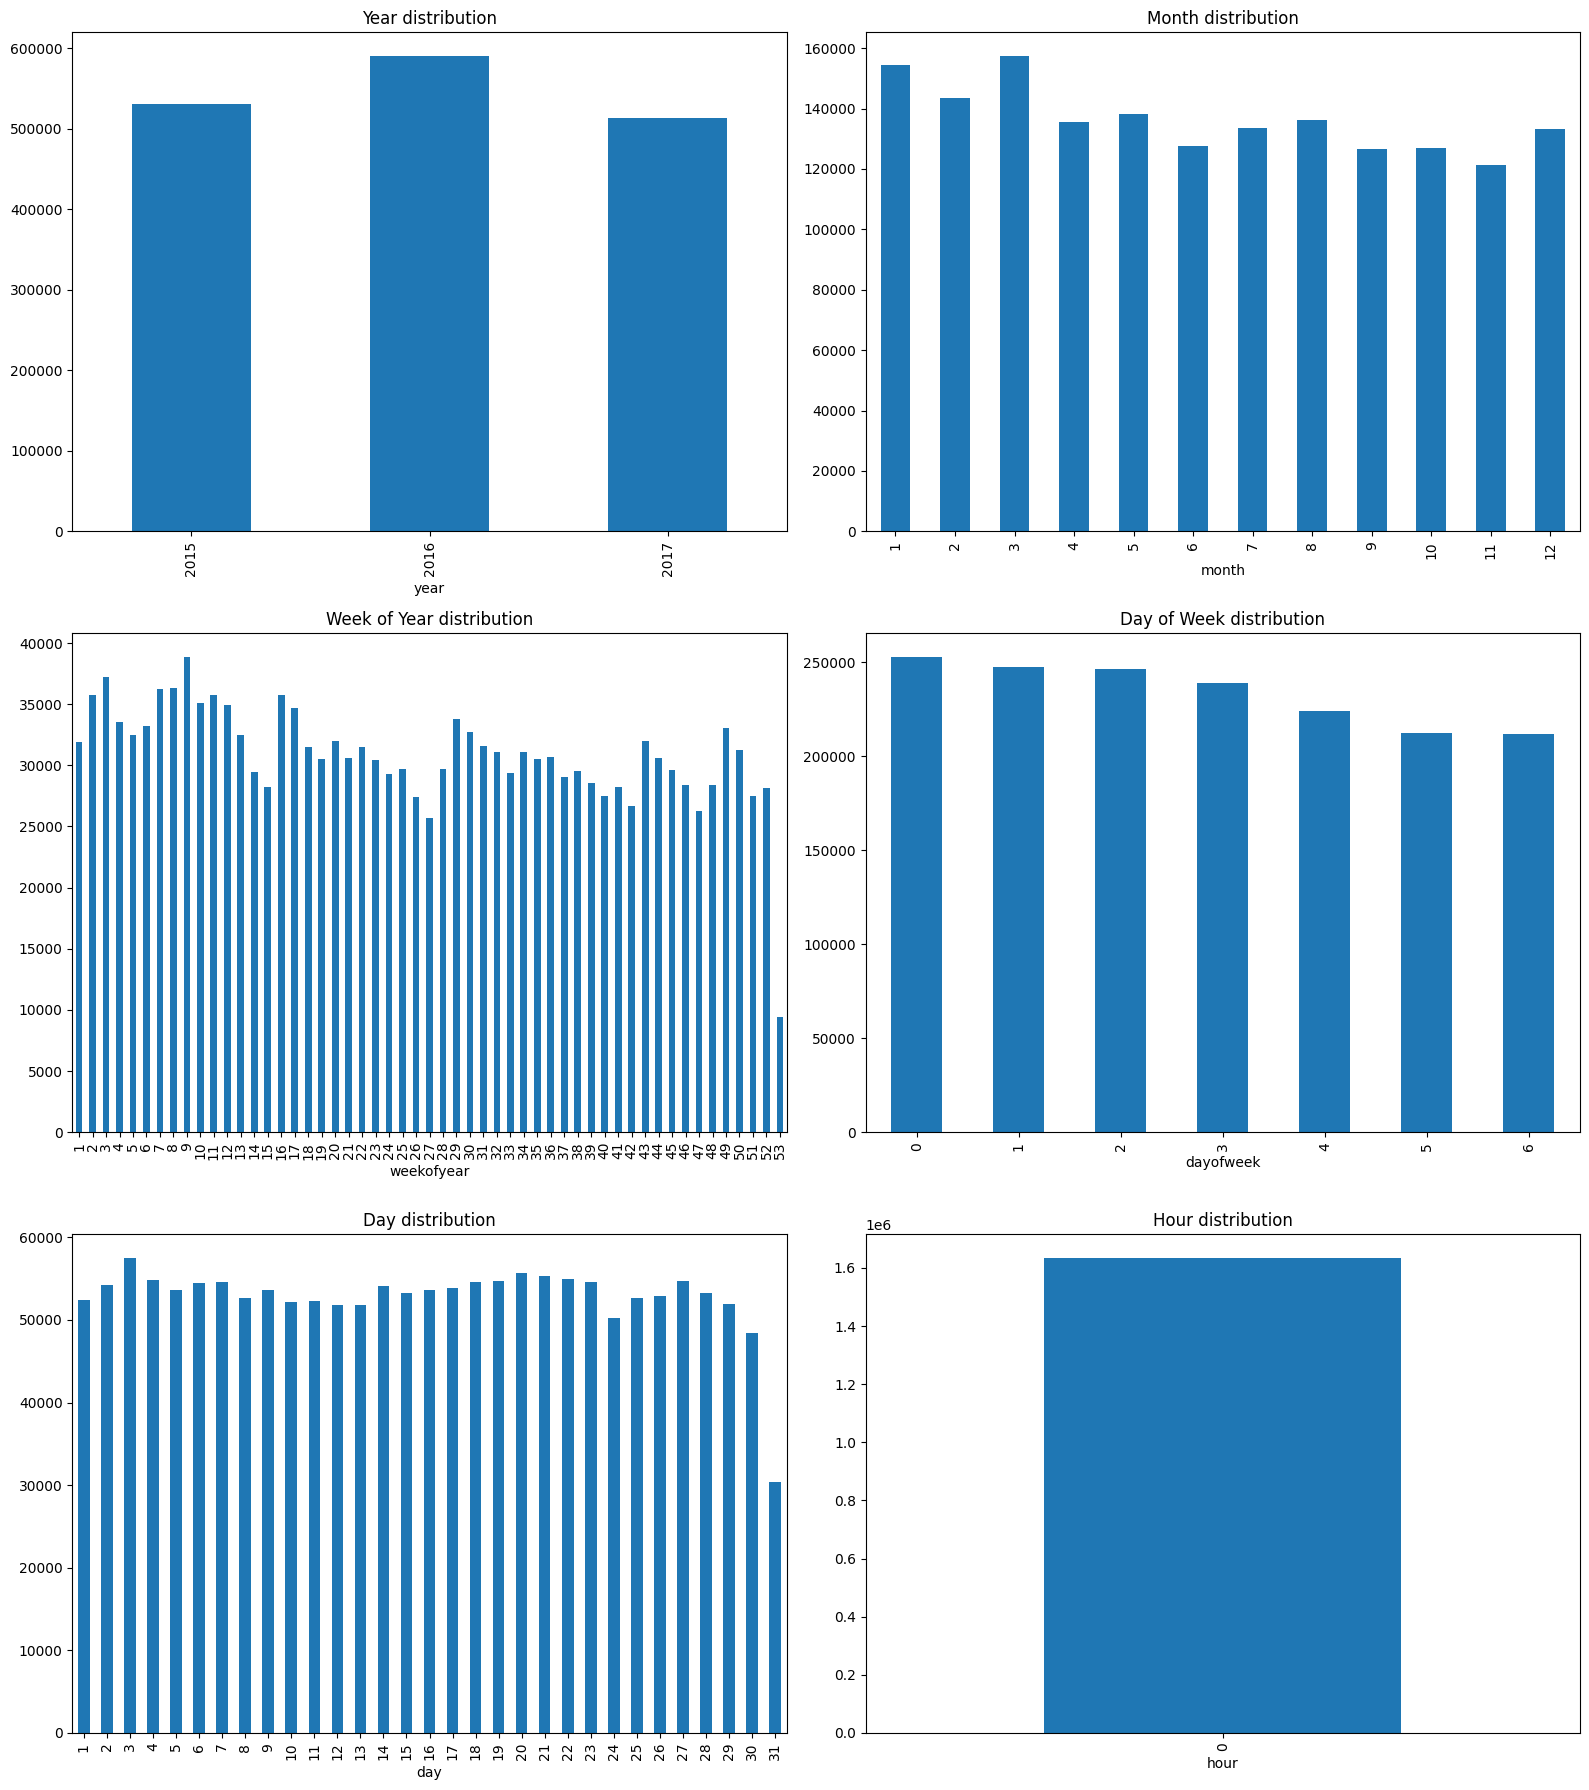

In [233]:
# Графики распределения
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
df_train_clip_clean["year"].value_counts().sort_index().plot(kind="bar", ax=axes[0, 0], title="Year distribution")
df_train_clip_clean["month"].value_counts().sort_index().plot(kind="bar", ax=axes[0, 1], title="Month distribution")
df_train_clip_clean["weekofyear"].value_counts().sort_index().plot(kind="bar", ax=axes[1, 0], title="Week of Year distribution")
df_train_clip_clean["dayofweek"].value_counts().sort_index().plot(kind="bar", ax=axes[1, 1], title="Day of Week distribution")
df_train_clip_clean["day"].value_counts().sort_index().plot(kind="bar", ax=axes[2, 0], title="Day distribution")
df_train_clip_clean["hour"].value_counts().sort_index().plot(kind="bar", ax=axes[2, 1], title="Hour distribution")
plt.tight_layout()
plt.show()

In [234]:
# Удалим поле hour, т.к. он не несёт полезной информации
df_train_clip_clean.drop("hour", axis=1, inplace=True)

In [235]:
# Циклическое кодирование признаков
def encode_cyclical(df, column, period):
    df[f"{column}_sin"] = np.sin(2 * np.pi * df[column] / period)
    df[f"{column}_cos"] = np.cos(2 * np.pi * df[column] / period)

In [236]:
encode_cyclical(df_train_clip_clean, "month", 12)
encode_cyclical(df_train_clip_clean, "weekofyear", 52)
encode_cyclical(df_train_clip_clean, "dayofweek", 7)
encode_cyclical(df_train_clip_clean, "day", 31)

In [237]:
# Посмотрим пример результата
df_train_clip_clean[["month_sin", "month_cos", "weekofyear_sin", "weekofyear_cos"]].head()

,month_sin,month_cos,weekofyear_sin,weekofyear_cos
0,0.5,0.866025,0.120537,0.992709
2,0.5,0.866025,0.120537,0.992709
3,0.5,0.866025,0.120537,0.992709
4,0.5,0.866025,0.120537,0.992709
5,0.5,0.866025,0.120537,0.992709


In [238]:
# Также сделаем агрегации по отдельным фичам
mean_label_by_month = df_train_clip_clean.groupby("month")["label"].mean().rename("month_mean_label")
mean_label_by_week = df_train_clip_clean.groupby("weekofyear")["label"].mean().rename("weekofyear_mean_label")
mean_label_by_dayofweek = df_train_clip_clean.groupby("dayofweek")["label"].mean().rename("dayofweek_mean_label")

In [239]:
# И агрегацию по группировке месяца и дня
mean_label_by_month_day = (
    df_train_clip_clean.groupby(["month", "day"])["label"]
    .mean().rename("month_day_mean_label")
    .reset_index()
)

In [ ]:
# Мерджим mean_label_by_month
df_train_clip_clean = df_train_clip_clean.merge(
    mean_label_by_month, on="month", how="left"
)

In [ ]:
# Мерджим mean_label_by_week
df_train_clip_clean = df_train_clip_clean.merge(
    mean_label_by_week, on="weekofyear", how="left"
)

In [ ]:
# Мерджим mean_label_by_dayofweek
df_train_clip_clean = df_train_clip_clean.merge(
    mean_label_by_dayofweek, on="dayofweek", how="left"
)

In [ ]:
# Мерджим по паре (month, day)
df_train_clip_clean = df_train_clip_clean.merge(
    mean_label_by_month_day, on=["month", "day"], how="left"
)

In [ ]:
# Проверим итоги извлечения фичей по датам
print("Итоговые колонки:", df_train_clip_clean.columns.tolist()[-19:])
print("Есть ли NaN:\n" + f"{df_train_clip_clean[[
    "month_mean_label",
    "weekofyear_mean_label",
    "dayofweek_mean_label",
    "month_day_mean_label"
]].isnull().sum()}")

Итоговые колонки: ['datetime', 'year', 'month', 'day_of_week', 'day', 'weekofyear', 'dayofweek', 'month_sin', 'month_cos', 'weekofyear_sin', 'weekofyear_cos', 'dayofweek_sin', 'dayofweek_cos', 'day_sin', 'day_cos', 'month_mean_label', 'weekofyear_mean_label', 'dayofweek_mean_label', 'month_day_mean_label']
Есть ли NaN:
month_mean_label         0
weekofyear_mean_label    0
dayofweek_mean_label     0
month_day_mean_label     0
dtype: int64


In [ ]:
from sklearn.preprocessing import StandardScaler

# Выбираем только признаки, которым нужно масштабирование
time_agg_cols = [
    "month_mean_label",
    "weekofyear_mean_label",
    "dayofweek_mean_label",
    "month_day_mean_label"
]

In [253]:
scaler = StandardScaler()
df_train_clip_clean[time_agg_cols] = scaler.fit_transform(df_train_clip_clean[time_agg_cols])

In [ ]:
# Проверим статистики по временным колонкам
print(df_train_clip_clean[time_agg_cols].describe().T)

                           count          mean  std       min       25%  \
month_mean_label       1635089.0  7.628215e-15  1.0 -1.685119 -0.616408   
weekofyear_mean_label  1635089.0  3.390645e-14  1.0 -2.398647 -0.693816   
dayofweek_mean_label   1635089.0  5.337470e-14  1.0 -0.978565 -0.654905   
month_day_mean_label   1635089.0  3.654968e-14  1.0 -3.990564 -0.618746   

                            50%       75%       max  
month_mean_label       0.374393  0.954283  1.159998  
weekofyear_mean_label  0.101899  0.796791  1.903079  
dayofweek_mean_label  -0.332282  0.367760  2.142411  
month_day_mean_label   0.080028  0.734942  2.399291  


In [270]:
df_train_time_final = df_train_clip_clean.copy()

In [271]:
# Загружаем тестовый датасет и обучающую выборку (rating-based sampling)
df_test = pd.read_csv("data/df_test_ground_truth_rating_based.csv")

In [272]:
# Выбираем CLIP-эмбеддинги (текст + изображение)
item_vector_cols = [col for col in df_train_time_final.columns if col.startswith("clip_text_") or col.startswith("clip_img_")]
user_ids = df_train_time_final["user_id"].unique()

In [273]:
# Извлекаем CLIP-эмбеддинги
clip_vectors  = df_train_time_final.drop_duplicates("item_id")[["item_id"] + item_vector_cols].set_index("item_id")

In [274]:
item_vectors = clip_vectors.copy()

In [275]:
print("clip_vectors shape:", clip_vectors.shape)
print("item_vectors shape:", item_vectors.shape)

clip_vectors shape: (67706, 200)
item_vectors shape: (67706, 200)


In [276]:
# Формируем вектор интересов пользователя как среднее по позитивным item-векторам
user_vectors = {}

In [278]:
for user_id, group in tqdm(df_train_time_final[df_train_time_final["label"] == 1].groupby("user_id"), desc="User vector aggregation", file=sys.stdout):
    item_ids = group["item_id"].values
    vectors = item_vectors.loc[item_ids].values
    user_vectors[user_id] = np.mean(vectors, axis=0)

User vector aggregation: 100%|██████████| 551853/551853 [02:49<00:00, 3252.76it/s]


In [279]:
# Строим датасет: конкатенируем векторы пользователя и товара
X = []
y = []

In [ ]:
# Выбираем все фичи по времени, кроме datetime и исходных признаков
time_cols = [
    'month_sin', 'month_cos',
    'weekofyear_sin', 'weekofyear_cos',
    'dayofweek_sin', 'dayofweek_cos',
    'day_sin', 'day_cos',
    'month_mean_label', 'weekofyear_mean_label',
    'dayofweek_mean_label', 'month_day_mean_label'
]

In [ ]:
# Формируем обучающие пары
for row in tqdm(df_train_time_final.itertuples(), total=len(df_train_time_final), desc="Building training vectors"):
    user_id = row.user_id
    item_id = row.item_id
    label = row.label

    if user_id not in user_vectors or item_id not in item_vectors.index:
        continue

    user_vec = user_vectors[user_id]
    item_vec = item_vectors.loc[item_id].values

    # Извлекаем фичи по времени из строки
    time_vec = np.array([getattr(row, col) for col in time_cols], dtype=np.float32)

    # Финальный вектор
    concat_vec = np.concatenate([user_vec, item_vec, time_vec])
    X.append(concat_vec)
    y.append(label)

Building training vectors: 100%|██████████| 1635089/1635089 [01:45<00:00, 15496.55it/s]


In [282]:
# Преобразуем списки в numpy-массивы
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1542533, 412)
y shape: (1542533,)


In [284]:
from sklearn.model_selection import train_test_split

In [ ]:
# Также произведем стратифицированный сплит
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

In [286]:
print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)

Train shape: (1388279, 412)
Val shape: (154254, 412)


In [ ]:
# Сплитим X на user/item/time вектора
user_dim = item_dim = 200  # 100 clip_text + 100 clip_img
time_dim = len(time_cols)  # число фичей, связанных с датой

In [289]:
X_user_train = X_train[:, :user_dim]
X_item_train = X_train[:, user_dim:user_dim*2]
X_time_train = X_train[:, -time_dim:]

In [294]:
X_user_val = X_val[:, :user_dim]
X_item_val = X_val[:, user_dim:user_dim*2]
X_time_val = X_val[:, -time_dim:]

In [298]:
print("User vector dim:", user_dim)
print("Time feature dim:", time_dim)

User vector dim: 200
Time feature dim: 12


In [ ]:
# Пользовательский Dataset с временными фичами
class TimeAwareMatchingDataset(Dataset):
    def __init__(self, user_vecs, item_vecs, time_feats, labels):
        self.user_vecs = torch.tensor(user_vecs, dtype=torch.float32)
        self.item_vecs = torch.tensor(item_vecs, dtype=torch.float32)
        self.time_feats = torch.tensor(time_feats, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            self.user_vecs[idx],
            self.item_vecs[idx],
            self.time_feats[idx],
            self.labels[idx]
        )

In [ ]:
# Создание Dataset и DataLoader
train_dataset = TimeAwareMatchingDataset(X_user_train, X_item_train, X_time_train, y_train)
val_dataset = TimeAwareMatchingDataset(X_user_val, X_item_val, X_time_val, y_val)

In [301]:
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False)

In [302]:
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

Train size: 1388279, Val size: 154254


**MLPWithTimeFeatures**  
Модель обучается на объединении эмбеддингов пользователя, товара и временных признаков.  
Позволяет учитывать сезонность и поведение во времени.

In [ ]:
# Архитектура one-head MLP модели
class MLPWithTimeFeatures(nn.Module):
    def __init__(self, user_dim, item_dim, time_dim):
        super().__init__()
        input_dim = user_dim + item_dim + time_dim
        self.model = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, user_vec, item_vec, time_vec):
        x = torch.cat([user_vec, item_vec, time_vec], dim=1)
        return self.model(x)

**TwoHeadMLPWithTimeFeatures**  
Раздельные энкодеры для пользователя и товара, объединённые с временными фичами в единую архитектуру.  
Гибридный подход, сочетающий мультимодальность и временную компоненту.

In [ ]:
# Архитектура two-head MLP модели
# которая предобрабатывает вектора юзеров и товаров
class TwoHeadMLPWithTimeFeatures(nn.Module):
    def __init__(self, user_dim, item_dim, time_dim):
        super().__init__()
        self.user_encoder = nn.Sequential(
            nn.Linear(user_dim, 128),
            nn.ReLU()
        )
        self.item_encoder = nn.Sequential(
            nn.Linear(item_dim, 128),
            nn.ReLU()
        )
        self.final_mlp = nn.Sequential(
            nn.BatchNorm1d(128 * 2 + time_dim),
            nn.Linear(128 * 2 + time_dim, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, user_vec, item_vec, time_vec):
        user_emb = self.user_encoder(user_vec)
        item_emb = self.item_encoder(item_vec)
        x = torch.cat([user_emb, item_emb, time_vec], dim=1)
        return self.final_mlp(x)

In [ ]:
# Не забудем также учесть дисбаланс классов
n_pos = np.sum(y == 1)
n_neg = np.sum(y == 0)
pos_weight = (n_neg + n_pos) / (2 * n_pos)
neg_weight = (n_neg + n_pos) / (2 * n_neg)

In [ ]:
# Инициируем модели, лосс и оптимайзеры
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [308]:
model_one_head = MLPWithTimeFeatures(user_dim, item_dim, time_dim).to(device)
model_two_head = TwoHeadMLPWithTimeFeatures(user_dim, item_dim, time_dim).to(device)

In [309]:
criterion = nn.BCELoss(reduction="none")
optimizer_one_head = torch.optim.Adam(model_one_head.parameters(), lr=1e-3)
optimizer_two_head = torch.optim.Adam(model_two_head.parameters(), lr=1e-3)

In [ ]:
# Функция обучения модели
def train_model(model, optimizer, name):
    for epoch in range(10):
        model.train()
        train_losses = []
        for u_vec, i_vec, t_vec, labels in tqdm(train_loader, desc=f"Training {name}", file=sys.stdout):
            u_vec = u_vec.to(device)
            i_vec = i_vec.to(device)
            t_vec = t_vec.to(device)
            labels = labels.to(device).view(-1, 1)

            preds = model(u_vec, i_vec, t_vec)
            loss_raw = criterion(preds, labels)
            weights = torch.where(labels == 1, pos_weight, neg_weight).to(device)
            loss = (loss_raw * weights).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # --- Validation ---
        model.eval()
        val_losses, all_preds, all_targets = [], [], []
        for u_vec, i_vec, t_vec, labels in tqdm(val_loader, desc=f"Validating {name}", file=sys.stdout):
            u_vec = u_vec.to(device)
            i_vec = i_vec.to(device)
            t_vec = t_vec.to(device)
            labels = labels.to(device).view(-1, 1)

            with torch.no_grad():
                preds = model(u_vec, i_vec, t_vec)
                loss_raw = criterion(preds, labels)
                weights = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                loss = (loss_raw * weights).mean()

            val_losses.append(loss.item())
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

        all_preds_bin = (np.array(all_preds) >= 0.5).astype(int)
        val_acc = accuracy_score(all_targets, all_preds_bin)
        tqdm.write(f"{name} Epoch {epoch+1}/10 | "
                   f"Train Loss: {np.mean(train_losses):.4f} | "
                   f"Val Loss: {np.mean(val_losses):.4f} | "
                   f"Val Accuracy: {val_acc:.4f}")

In [ ]:
# Обучение one-head модели
train_model(model_one_head, optimizer_one_head, "MLP+Time")

Validating MLP+Time: 100%|██████████| 76/76 [00:03<00:00, 20.27it/s]
MLP+Time Epoch 1/10 | Train Loss: 0.2427 | Val Loss: 0.1591 | Val Accuracy: 0.9418
Validating MLP+Time: 100%|██████████| 76/76 [00:02<00:00, 26.91it/s]
MLP+Time Epoch 2/10 | Train Loss: 0.1486 | Val Loss: 0.1344 | Val Accuracy: 0.9569
Validating MLP+Time: 100%|██████████| 76/76 [00:02<00:00, 26.77it/s]
MLP+Time Epoch 3/10 | Train Loss: 0.1236 | Val Loss: 0.1305 | Val Accuracy: 0.9683
Validating MLP+Time: 100%|██████████| 76/76 [00:03<00:00, 19.84it/s]
MLP+Time Epoch 4/10 | Train Loss: 0.1121 | Val Loss: 0.1274 | Val Accuracy: 0.9663
Validating MLP+Time: 100%|██████████| 76/76 [00:03<00:00, 23.53it/s]
MLP+Time Epoch 5/10 | Train Loss: 0.1035 | Val Loss: 0.1277 | Val Accuracy: 0.9674
Validating MLP+Time: 100%|██████████| 76/76 [00:03<00:00, 22.97it/s]
MLP+Time Epoch 6/10 | Train Loss: 0.0974 | Val Loss: 0.1260 | Val Accuracy: 0.9688
Validating MLP+Time: 100%|██████████| 76/76 [00:03<00:00, 21.83it/s]
MLP+Time Epoch 7/10

In [ ]:
# Обучение two-head модели
train_model(model_two_head, optimizer_two_head, "TwoHead+Time")

Validating TwoHead+Time: 100%|██████████| 76/76 [00:02<00:00, 27.80it/s]
TwoHead+Time Epoch 1/10 | Train Loss: 0.3026 | Val Loss: 0.2112 | Val Accuracy: 0.9308
Validating TwoHead+Time: 100%|██████████| 76/76 [00:03<00:00, 19.70it/s]
TwoHead+Time Epoch 2/10 | Train Loss: 0.1935 | Val Loss: 0.1794 | Val Accuracy: 0.9379
Validating TwoHead+Time: 100%|██████████| 76/76 [00:03<00:00, 23.13it/s]
TwoHead+Time Epoch 3/10 | Train Loss: 0.1655 | Val Loss: 0.1666 | Val Accuracy: 0.9447
Validating TwoHead+Time: 100%|██████████| 76/76 [00:03<00:00, 22.68it/s]
TwoHead+Time Epoch 4/10 | Train Loss: 0.1495 | Val Loss: 0.1601 | Val Accuracy: 0.9509
Validating TwoHead+Time: 100%|██████████| 76/76 [00:03<00:00, 22.54it/s]
TwoHead+Time Epoch 5/10 | Train Loss: 0.1383 | Val Loss: 0.1584 | Val Accuracy: 0.9529
Validating TwoHead+Time: 100%|██████████| 76/76 [00:02<00:00, 27.13it/s]
TwoHead+Time Epoch 6/10 | Train Loss: 0.1299 | Val Loss: 0.1556 | Val Accuracy: 0.9559
Validating TwoHead+Time: 100%|██████████

In [ ]:
# Переводим модели в режим инференса
model_one_head.eval()
model_two_head.eval()

TwoHeadMLPWithTimeFeatures(
  (user_encoder): Sequential(
    (0): Linear(in_features=200, out_features=128, bias=True)
    (1): ReLU()
  )
  (item_encoder): Sequential(
    (0): Linear(in_features=200, out_features=128, bias=True)
    (1): ReLU()
  )
  (final_mlp): Sequential(
    (0): BatchNorm1d(268, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=268, out_features=256, bias=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [ ]:
# Подготавливаем список кандидатов и их эмбеддинги для инференса
candidate_items = item_vectors.index.tolist()
candidate_vectors = item_vectors.values

In [ ]:
# Словари для хранения предсказаний
predictions_one_head = {}
predictions_two_head = {}

In [ ]:
# Т.к. тест у нас на оставшийся 2018 год
# то возьмем первый день этого года за отправную точку
# для предсказаний и сформируем фичи дат
# потому что наши модели в этом блоке потребляют
# помимо векторов юзера и товара, еще и временные фичи
inference_date = pd.Timestamp("2018-01-01")

In [319]:
# Циклические признаки
inference_features = {
    "month": inference_date.month,
    "weekofyear": inference_date.isocalendar().week,
    "dayofweek": inference_date.dayofweek,
    "day": inference_date.day
}

In [321]:
inference_cyclical = {
    key: value
    for k, v, p in [
        ("month", inference_features["month"], 12),
        ("weekofyear", inference_features["weekofyear"], 52),
        ("dayofweek", inference_features["dayofweek"], 7),
        ("day", inference_features["day"], 31)
    ]
    for key, value in [
        (f"{k}_sin", np.sin(2 * np.pi * v / p)),
        (f"{k}_cos", np.cos(2 * np.pi * v / p))
    ]
}

In [323]:
# Пытаемся найти соответствующие агрегации в df_train_time_final
agg_defaults = {}

In [324]:
# По month
val = df_train_time_final[df_train_time_final["month"] == inference_features["month"]]["month_mean_label"]
agg_defaults["month_mean_label"] = val.iloc[0] if not val.empty else 0.0

In [325]:
# По weekofyear
val = df_train_time_final[df_train_time_final["weekofyear"] == inference_features["weekofyear"]]["weekofyear_mean_label"]
agg_defaults["weekofyear_mean_label"] = val.iloc[0] if not val.empty else 0.0

In [326]:
# По dayofweek
val = df_train_time_final[df_train_time_final["dayofweek"] == inference_features["dayofweek"]]["dayofweek_mean_label"]
agg_defaults["dayofweek_mean_label"] = val.iloc[0] if not val.empty else 0.0

In [327]:
# По паре (month, day)
val = df_train_time_final[
    (df_train_time_final["month"] == inference_features["month"]) &
    (df_train_time_final["day"] == inference_features["day"])
]["month_day_mean_label"]
agg_defaults["month_day_mean_label"] = val.iloc[0] if not val.empty else 0.0

In [328]:
# Объединяем с ранее посчитанными циклическими фичами
inference_time_features = {**inference_cyclical, **agg_defaults}

In [331]:
# Превращаем в torch-тензор
inference_time_tensor = torch.tensor(
    list(inference_time_features.values()), dtype=torch.float32
).unsqueeze(0).to(device)

In [ ]:
# Формируем топы рекомендаций для каждого юзера
for user_id in tqdm(ground_truth.keys(), desc="Generating Top-10 (Time-aware models)", file=sys.stdout):
    if user_id not in user_vectors:
        continue

    user_vec = user_vectors[user_id]
    user_vec_batch = np.tile(user_vec, (candidate_vectors.shape[0], 1))
    user_tensor = torch.tensor(user_vec_batch, dtype=torch.float32).to(device)
    item_tensor = torch.tensor(candidate_vectors, dtype=torch.float32).to(device)

    # Один и тот же вектор времени повторяется для всех кандидатов
    time_tensor = inference_time_tensor.repeat(candidate_vectors.shape[0], 1)

    with torch.no_grad():
        # One-head model
        scores_one_head = model_one_head(user_tensor, item_tensor, time_tensor).cpu().numpy().flatten()
        sorted_items_one_head = np.array(candidate_items)[np.argsort(scores_one_head)[::-1]]
        predictions_one_head[user_id] = sorted_items_one_head[:10].tolist()

        # Two-head model
        scores_two_head = model_two_head(user_tensor, item_tensor, time_tensor).cpu().numpy().flatten()
        sorted_items_two_head = np.array(candidate_items)[np.argsort(scores_two_head)[::-1]]
        predictions_two_head[user_id] = sorted_items_two_head[:10].tolist()

Generating Top-10 (Time-aware models): 100%|██████████| 85083/85083 [3:22:56<00:00,  6.99it/s]  


In [ ]:
# Выведем метрики, полученные в этом блоке
print("\nMLP+Time model (top-10)")
print("Precision@10:", precision_at_k(predictions_one_head, ground_truth))
print("MAP@10:", map_at_k(predictions_one_head, ground_truth))

print("\nTwoHeadMLP+Time model (top-10)")
print("Precision@10:", precision_at_k(predictions_two_head, ground_truth))
print("MAP@10:", map_at_k(predictions_two_head, ground_truth))


MLP+Time model (top-10)
Precision@10: 0.0021
MAP@10: 0.006

TwoHeadMLP+Time model (top-10)
Precision@10: 0.0015
MAP@10: 0.0048


### Вывод: Модели с временными признаками

- MLP+Time и TwoHead+Time не превзошли CLIP-style cosine model по качеству.
- Возможно, временные признаки переусложнили модель на текущем объеме данных.
- Могут быть полезны в reranker или Late Fusion, но не в retrieval напрямую.

In [ ]:
# Выведем метрики победителя предыдщуих блоков
print("\nCLIP-style cosine model (top-10)")
print("Precision@10:", precision_at_k(predictions_clip, ground_truth))
print("MAP@10:", map_at_k(predictions_clip, ground_truth))


CLIP-style cosine model (top-10)
Precision@10: 0.0032
MAP@10: 0.008


## Финальный вывод по экспериментам

- Наилучшие метрики показала модель `CLIP-style Cosine`:
  - Precision@10 ≈ **0.0032**
  - MAP@10 ≈ **0.008**
- Модели на основе временных признаков и user-фичей не показали улучшений.
- Потенциал — в расширении архитектур, улучшении сэмплинга и использовании двухступенчатых подходов.


## Roadmap: следующие шаги по улучшению модели до питчинг

1. **Контрастивное обучение**:
   - CLIP-like архитектура с `f_user`, `f_item`
   - Triplet loss / InfoNCE
   - Нормализация выходов, dot-product

2. **Ранжирующие функции потерь**:
   - BPR, LambdaRank

3. **Smart negative sampling**:
   - hard negatives на основе семантики

4. **Двухступенчатая архитектура**:
   - Retrieval (CLIP) → Reranker (MLP или GBDT)

5. **Late Fusion**:
   - `score = α * clip_score + β * time_model + γ * popularity_model`

6. **Post-filtering / Reranking**:
   - WDC(датасет для тренировки на дедупликацию), LightGBM, Cross-encoders для top-N

7. **Расширение эмбеддингов**:
   - TF-IDF, BERT, табличные признаки

8. **FAISS / ApproxNN для retrieval**
   - сейчас рассчитывается в отдельном блоке

9. **Сезонный анализ**:
   - по стабильным пользователям, праздникам, пикам

10. **Анализ explainability**:
   - для каких категорий и пользователей модель даёт хорошие рекомендации, а для каких —  нет. Где можно усилить качество предсказаний.
